# Recommender System with Collaborative Filtering

First, we need to read the data from the dataset.

In [127]:
import pandas as pd
import numpy as np

In [128]:
datasets_loc = "datasets"
# datasets_loc = "toy_datasets"
user_limit = 1000

In [129]:
ratings = pd.read_csv(datasets_loc + "/ratings.csv", delim_whitespace=True, skiprows=1, names=["UserID", "ProfileID", "Rating"])
# gender = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender"]) (For large dataset)
info = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender", "Name"])

Here is our data. UserID is the user, ProfileID is the profile that user is looking at.

In [130]:
ratings.head()

,UserID,ProfileID,Rating
0,3,1,1
1,3,2,5
2,3,3,1
3,3,4,1
4,3,5,10


In [131]:
info.head()

,UserID,Gender,Name
0,1,F,Anna
1,2,F,Sarah
2,3,M,Bob
3,4,M,Peter
4,5,F,Mary


In [132]:
ratings = pd.merge(info, ratings)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,Anna,2,1
1,1,F,Anna,3,8
2,1,F,Anna,4,10
3,1,F,Anna,6,2
4,1,F,Anna,8,1
...,...,...,...,...,...
63,10,F,Helen,8,1
64,11,F,Emma,3,6
65,11,F,Emma,8,1
66,11,F,Emma,9,10


We map the rating to like/ dislike. Rating smaller than 5 will consider as a dislike to the profile.

In [133]:
ratings["Rating"] = np.where(ratings["Rating"] < 5, -1, 1)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,Anna,2,-1
1,1,F,Anna,3,1
2,1,F,Anna,4,1
3,1,F,Anna,6,-1
4,1,F,Anna,8,-1
...,...,...,...,...,...
63,10,F,Helen,8,-1
64,11,F,Emma,3,1
65,11,F,Emma,8,-1
66,11,F,Emma,9,1


Due to large data set, we need to reduce the data records.

In [134]:
ratings = ratings[(ratings["UserID"] <= user_limit) & (ratings["ProfileID"] <= user_limit)]
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,Anna,2,-1
1,1,F,Anna,3,1
2,1,F,Anna,4,1
3,1,F,Anna,6,-1
4,1,F,Anna,8,-1
...,...,...,...,...,...
63,10,F,Helen,8,-1
64,11,F,Emma,3,1
65,11,F,Emma,8,-1
66,11,F,Emma,9,1


# Preparing data for Collaborative Filtering  

In [135]:
# Full list of rating
user_ratings = ratings.pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
user_ratings.head()

Rating                                                  
ProfileID     1    2    3    4    5    6    7    8    9    10   11
UserID                                                            
1            NaN -1.0  1.0  1.0  NaN -1.0 -1.0 -1.0  NaN  NaN  NaN
2            NaN  NaN -1.0  1.0  NaN -1.0 -1.0 -1.0  1.0  NaN -1.0
3           -1.0  1.0 -1.0 -1.0  1.0 -1.0  NaN  1.0 -1.0  NaN  NaN
4            1.0 -1.0  NaN  NaN  1.0 -1.0  NaN  NaN  NaN  NaN  NaN
5            NaN -1.0  NaN  1.0  NaN -1.0  1.0 -1.0  1.0 -1.0  NaN

In [136]:
# Clear pivot table structure to extra index and columns

user_ratings_df = user_ratings.copy()

user_ratings_df.columns = user_ratings_df.columns.droplevel(0)
user_ratings_df.name = None
user_ratings_df = user_ratings_df.reset_index()
user_ratings_df.index = user_ratings_df["UserID"]
user_ratings_df.index.name = "UserID"
user_ratings_df.drop("UserID", axis="columns", inplace=True)

user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,NaN,-1.0,1.0,1.0,NaN,-1.0,-1.0,-1.0,NaN,NaN,NaN
2,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,-1.0,1.0,NaN,-1.0
3,-1.0,1.0,-1.0,-1.0,1.0,-1.0,NaN,1.0,-1.0,NaN,NaN
4,1.0,-1.0,NaN,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN
5,NaN,-1.0,NaN,1.0,NaN,-1.0,1.0,-1.0,1.0,-1.0,NaN
6,1.0,1.0,-1.0,NaN,-1.0,NaN,-1.0,1.0,NaN,1.0,NaN
7,1.0,1.0,NaN,NaN,1.0,-1.0,NaN,-1.0,-1.0,1.0,1.0
8,NaN,NaN,1.0,1.0,NaN,NaN,-1.0,NaN,-1.0,-1.0,-1.0
9,-1.0,1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,NaN,1.0


In [137]:
from sklearn.model_selection import train_test_split

train_user_ratings, test_user_ratings = train_test_split(ratings, test_size=0.2)

test_user_ratings = test_user_ratings.drop(columns=["Gender", "Name"])
train_user_ratings = train_user_ratings.drop(columns=["Gender", "Name"])

In [138]:
test_user_ratings

,UserID,ProfileID,Rating
51,8,10,-1
62,10,7,1
2,1,4,1
59,10,2,-1
66,11,9,1
6,2,3,-1
67,11,10,-1
29,5,7,1
49,8,7,-1
56,9,6,-1


In [139]:
# Create pivot table with test data fill with 0
train_user_ratings_pivot = pd.concat([train_user_ratings, test_user_ratings.assign(Rating=0)]).pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
train_user_ratings_pivot.head()

Rating                                                  
ProfileID     1    2    3    4    5    6    7    8    9    10   11
UserID                                                            
1            NaN -1.0  1.0  0.0  NaN -1.0 -1.0  0.0  NaN  NaN  NaN
2            NaN  NaN  0.0  1.0  NaN -1.0 -1.0 -1.0  1.0  NaN -1.0
3           -1.0  1.0 -1.0 -1.0  1.0 -1.0  NaN  1.0 -1.0  NaN  NaN
4            1.0  0.0  NaN  NaN  1.0 -1.0  NaN  NaN  NaN  NaN  NaN
5            NaN -1.0  NaN  1.0  NaN -1.0  0.0 -1.0  1.0 -1.0  NaN

So here, we fill all NaN to 0. 

In [140]:
train_user_ratings_pivot = train_user_ratings_pivot.fillna(0)
train_user_ratings_pivot.head()

Rating                                                  
ProfileID     1    2    3    4    5    6    7    8    9    10   11
UserID                                                            
1            0.0 -1.0  1.0  0.0  0.0 -1.0 -1.0  0.0  0.0  0.0  0.0
2            0.0  0.0  0.0  1.0  0.0 -1.0 -1.0 -1.0  1.0  0.0 -1.0
3           -1.0  1.0 -1.0 -1.0  1.0 -1.0  0.0  1.0 -1.0  0.0  0.0
4            1.0  0.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0  0.0  0.0
5            0.0 -1.0  0.0  1.0  0.0 -1.0  0.0 -1.0  1.0 -1.0  0.0

In [141]:
# Clear pivot table structure to extra index and columns

train_user_ratings_df = train_user_ratings_pivot.copy()

train_user_ratings_df.columns = train_user_ratings_df.columns.droplevel(0)
train_user_ratings_df.name = None
train_user_ratings_df = train_user_ratings_df.reset_index()
train_user_ratings_df.index = train_user_ratings_df["UserID"]
train_user_ratings_df.index.name = "UserID"
train_user_ratings_df.drop("UserID", axis="columns", inplace=True)

train_user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0
3,-1.0,1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.0
6,1.0,1.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,-1.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
9,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Item-based Collaborative Filtering with Cosine Similarity
With KNN algorithm, we can find the similar profiles to the profile that user is looking at. 

In [142]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(train_user_ratings_df.T)

# Here, skipped the cosine similarity matrix

# Same dataset (traning and testing), so nearest is itself (For now)
distances, indices = knn.kneighbors(train_user_ratings_df.T.values, n_neighbors=3)

In [143]:
# Predict like/ dislike for a Profile by a User

def findNearestProfiles(profile_id):
    # Get the index for a profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)

    # Find the indices for similar profiles
    sim_profiles = indices[index_of_profile].tolist()

    # Find the distances between the profile and similar profiles
    sim_profiles_distances = distances[index_of_profile].tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if index_of_profile in sim_profiles:
        # The position of the profile in the list of similar profiles
        index_of_profile_in_sim = sim_profiles.index(index_of_profile)

        # Remove the profile from the list of similar profiles
        sim_profiles.pop(index_of_profile_in_sim)

        # Remove the profile from the list of similar profiles distances
        sim_profiles_distances.pop(index_of_profile_in_sim)

    # print("The nearest profiles to Profile {} are:".format(profile_id), ["Profile {}".format(train_user_ratings_df.columns[i]) for i in sim_profiles])
    # print("The distance from Profile {}:".format(profile_id), sim_profiles_distances)
    # print("Returned", sim_profiles, sim_profiles_distances)
    return sim_profiles, sim_profiles_distances

# findNearestProfiles(1)

In [144]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the profile
    profile_ratings = train_user_ratings_df.T.iloc[index_of_profile].values.tolist()

    # Find the nearest neighbors of the profile
    sim_profiles, sim_profiles_distances = findNearestProfiles(profile_id)
    
    # Get the ratings for the similar profiles
    sim_profiles_ratings = [train_user_ratings_df.T.iloc[i].values.tolist() for i in sim_profiles]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_profiles_distances[i] * (sim_profiles_ratings[i][index_of_user] - average(train_user_ratings_df.T.iloc[sim_profiles[i]].values.tolist())) for i in range(len(sim_profiles))])
    denominator = sum(sim_profiles_distances)

    if denominator > 0:
        predicted_rating = average(profile_ratings) + numerator / denominator 
    else:
        predicted_rating = average(profile_ratings)

    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(5, 4)

In [145]:
def recommender_system_item_based_CF(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if test_user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [146]:
# Generating entire item-based prediction matrix
predicted_ratings = train_user_ratings_df.T.copy()

for user_id in train_user_ratings_df.index:
    recommender_system_item_based_CF(user_id)
pd.DataFrame(predicted_ratings)

UserID,1,2,3,4,5,6,7,8,9,10,11
ProfileID,,,,,,,,,,,
1,0.051601,0.619217,-0.516014,0.051601,0.186832,0.483986,0.483986,0.619217,-0.516014,-0.516014,0.051601
2,0.208565,-0.438544,0.855675,0.208565,-0.791435,1.208565,-0.085654,0.208565,0.855675,-0.438544,0.208565
3,0.181818,1.181818,-0.818182,0.181818,1.181818,0.181818,-0.306686,0.693314,-0.329677,-0.329677,0.181818
4,-0.056445,0.322661,-1.056445,0.564449,0.322661,0.564449,0.185344,-0.056445,-0.677339,-0.056445,-0.056445
5,-0.172194,-0.685427,0.314573,0.314573,0.314573,-0.172194,0.827806,-0.198660,0.827806,0.314573,0.314573
6,-0.809046,-1.375767,0.190954,-0.375767,-0.942488,-0.242325,-0.942488,-0.375767,0.190954,-0.942488,-0.375767
7,-0.570813,-0.570813,0.002873,0.002873,-0.570813,-0.718185,0.002873,-0.144499,-0.144499,-0.144499,-0.144499
8,-0.863416,-0.426219,0.010979,-0.426219,-0.863416,0.573781,0.010979,0.136584,0.573781,0.136584,0.136584
9,0.550206,0.205257,-1.122268,-0.122268,0.205257,-0.794743,-0.122268,0.877732,-0.449794,0.222681,0.550206


In [147]:
user_ratings.T

UserID             1    2    3    4    5    6    7    8    9    10   11
       ProfileID                                                       
Rating 1          NaN  NaN -1.0  1.0  NaN  1.0  1.0  NaN -1.0  NaN  NaN
       2         -1.0  NaN  1.0 -1.0 -1.0  1.0  1.0  NaN  1.0 -1.0  NaN
       3          1.0 -1.0 -1.0  NaN  NaN -1.0  NaN  1.0  NaN  1.0  1.0
       4          1.0  1.0 -1.0  NaN  1.0  NaN  NaN  1.0 -1.0 -1.0  NaN
       5          NaN  NaN  1.0  1.0  NaN -1.0  1.0  NaN  NaN  NaN  NaN
       6         -1.0 -1.0 -1.0 -1.0 -1.0  NaN -1.0  NaN -1.0  NaN  NaN
       7         -1.0 -1.0  NaN  NaN  1.0 -1.0  NaN -1.0  NaN  1.0  NaN
       8         -1.0 -1.0  1.0  NaN -1.0  1.0 -1.0  NaN  1.0 -1.0 -1.0
       9          NaN  1.0 -1.0  NaN  1.0  NaN -1.0 -1.0  NaN  NaN  1.0
       10         NaN  NaN  NaN  NaN -1.0  1.0  1.0 -1.0  NaN  NaN -1.0
       11         NaN -1.0  NaN  NaN  NaN  NaN  1.0 -1.0  1.0  NaN  NaN

In [148]:
# Turn pivot like table to original dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings.to_records())
predicted_ratings_df = predicted_ratings_df.melt(id_vars=["ProfileID"], var_name="UserID", value_name="Rating")
predicted_ratings_df = predicted_ratings_df.astype({"UserID": int, "ProfileID": int, "Rating": float})
predicted_ratings_df = predicted_ratings_df[["UserID", "ProfileID", "Rating"]]
predicted_ratings_df

,UserID,ProfileID,Rating
0,1,1,0.051601
1,1,2,0.208565
2,1,3,0.181818
3,1,4,-0.056445
4,1,5,-0.172194
...,...,...,...
116,11,7,-0.144499
117,11,8,0.136584
118,11,9,0.550206
119,11,10,-0.034291


In [149]:
test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index()

Rating
UserID ProfileID        
1      4               1
       8              -1
2      3              -1
4      2              -1
5      7               1
8      7              -1
       9              -1
       10             -1
9      6              -1
10     2              -1
       7               1
11     8              -1
       9               1
       10             -1

In [150]:

# Get only ratings that UserID and ProfileID exist in train_user_ratings
predicted_ratings_for_train = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(train_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      2          0.208565
       3          0.181818
       6         -0.809046
       7         -0.570813
2      4          0.322661

In [151]:
# Get only ratings that UserID and ProfileID exist in test_user_ratings
predicted_ratings_for_test = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(test_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      4         -0.056445
       8         -0.863416
2      3          1.181818
4      2          0.208565
5      7         -0.570813

In [152]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

# Root mean squared error for the training set
rmse_train = np.sqrt(mean_squared_error(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_train

0.6762290332665172

<AxesSubplot:title={'center':'Confusion Matrix for Training Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

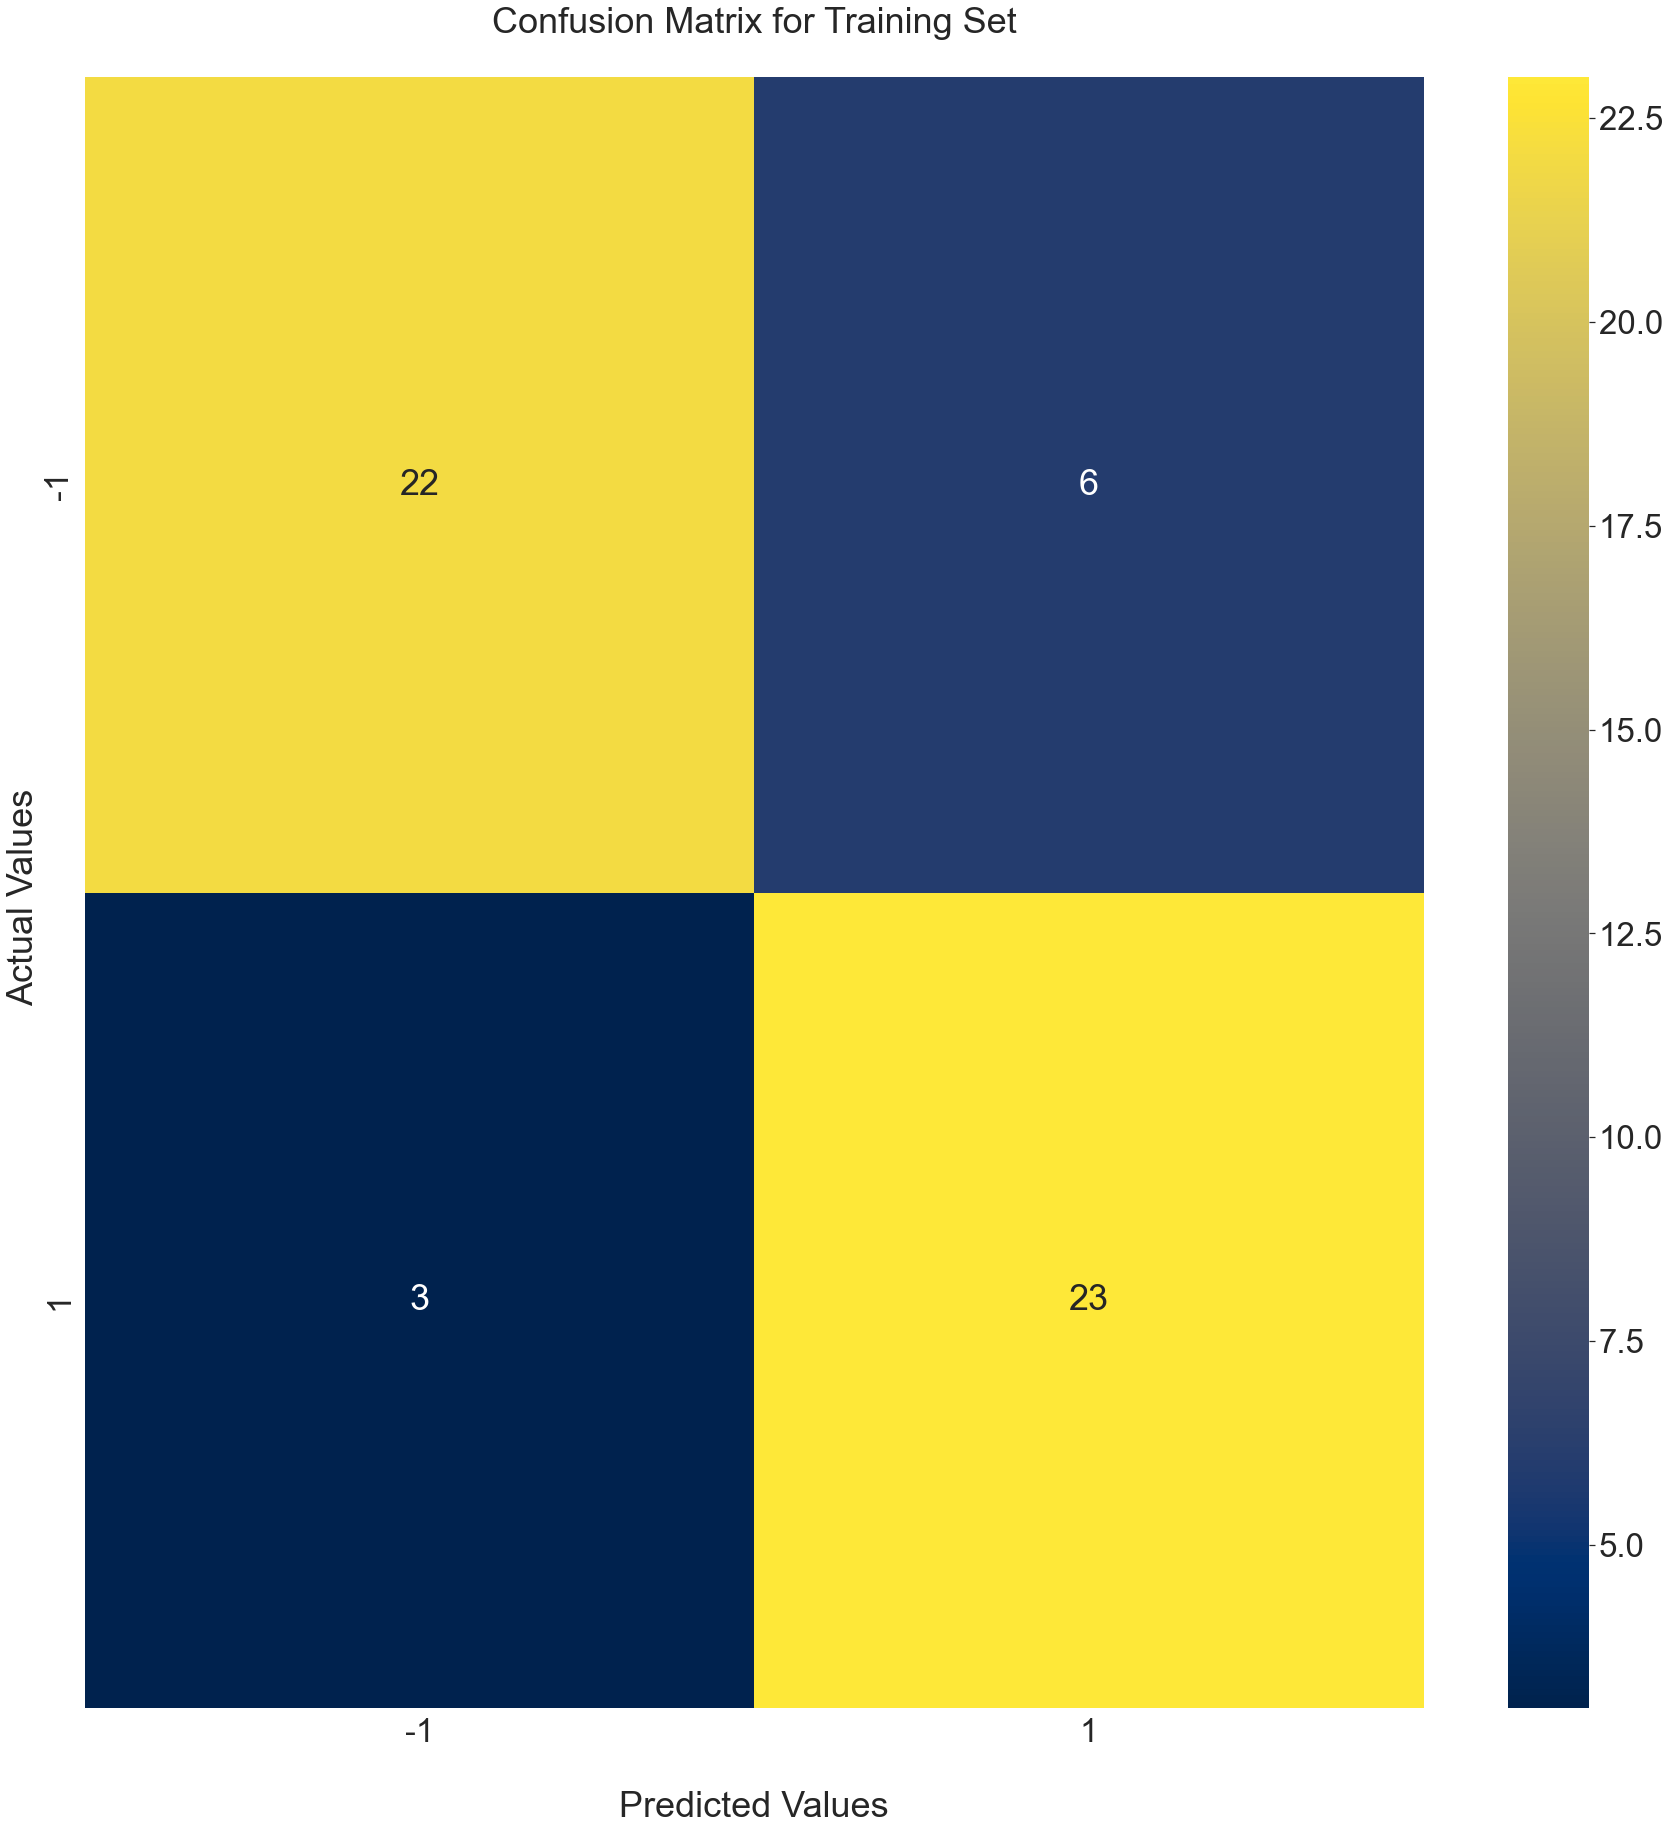

In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0]
cf_matrix = confusion_matrix(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], np.select([pred<=0, pred>0], [-1, 1], 0))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Training Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1', '1'])
ax.yaxis.set_ticklabels(['-1', '1'])
ax

In [154]:

# Root mean squared error for the test set
rmse_test = np.sqrt(mean_squared_error(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_test

1.2095958620611116

<AxesSubplot:title={'center':'Confusion Matrix for Test Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

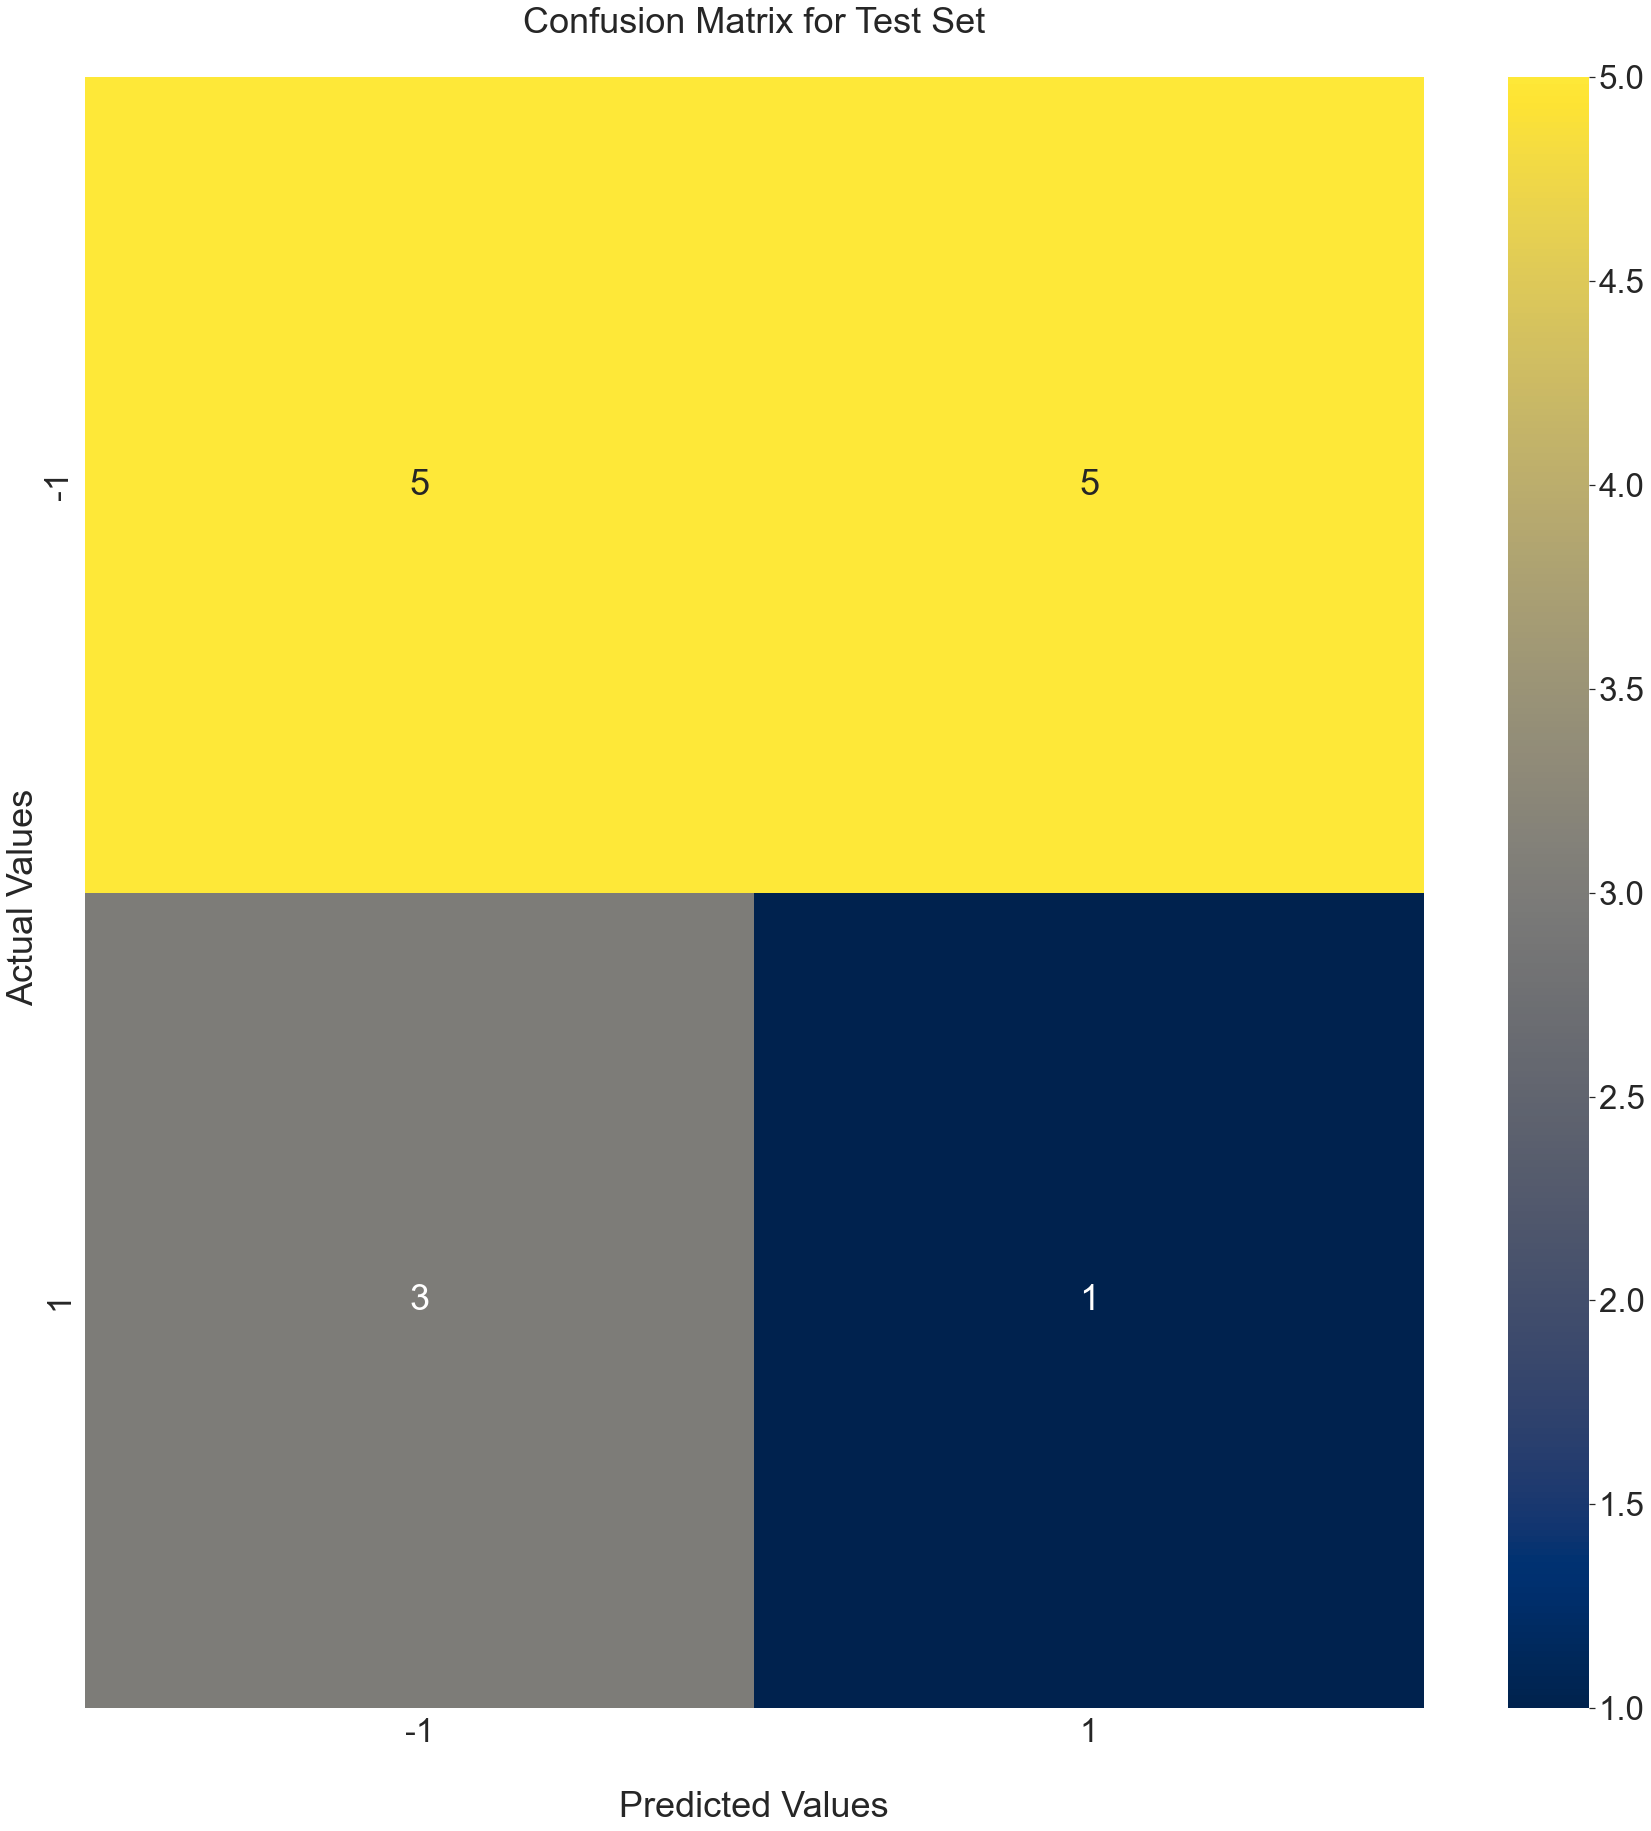

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0]
cf_matrix = confusion_matrix(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], np.select([pred<=0, pred>0], [-1, 1], 0))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Test Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1', '1'])
ax.yaxis.set_ticklabels(['-1', '1'])
ax

In [156]:
# Recommender system for a random user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_item_based_CF(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Helen:


# User-based Collaborative Filtering with Cosine Similarity

In [157]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(train_user_ratings_df)

# Here, skipped the cosine similarity matrix

# Same dataset (traning and testing), so nearest is itself (For now)
distances, indices = knn.kneighbors(train_user_ratings_df.values, n_neighbors=3)

In [158]:
# Predict like/ dislike for a User by a User

def findNearestUsers(user_id):
    # Get the index for a user
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Find the indices for similar users
    sim_users = indices[index_of_user].tolist()

    # Find the distances between the user and similar users
    sim_users_distances = distances[index_of_user].tolist()

    # Case when the target user is not in the list, multiple values are the same
    if index_of_user in sim_users:
        # The position of the user in the list of similar users
        index_of_user_in_sim = sim_users.index(index_of_user)

        # Remove the user from the list of similar users
        sim_users.pop(index_of_user_in_sim)

        # Remove the user from the list of similar users distances
        sim_users_distances.pop(index_of_user_in_sim)

    return sim_users, sim_users_distances

# findNearestProfiles(1)

In [159]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the user
    user_ratings = train_user_ratings_df.iloc[index_of_user].values.tolist()

    # Find the nearest neighbors of the user
    sim_users, sim_users_distances = findNearestUsers(user_id)
    
    # Get the ratings for the similar users
    sim_users_ratings = [train_user_ratings_df.iloc[i].values.tolist() for i in sim_users]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_users_distances[i] * (sim_users_ratings[i][index_of_profile] - average(train_user_ratings_df.iloc[sim_users[i]].values.tolist())) for i in range(len(sim_users))])
    denominator = sum(sim_users_distances)

    if denominator > 0:
        predicted_rating = average(user_ratings) + numerator / denominator 
    else:
        predicted_rating = average(user_ratings)


    return predicted_rating

# predict_rating_with_neighbor_correlations(5, 4)

In [160]:
def recommender_system_user_based_CF(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if test_user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [161]:
# Generating entire user-based prediction matrix
predicted_ratings = train_user_ratings_df.T.copy()

for user_id in train_user_ratings_df.index:
    recommender_system_user_based_CF(user_id)
pd.DataFrame(predicted_ratings)

UserID,1,2,3,4,5,6,7,8,9,10,11
ProfileID,,,,,,,,,,,
1,-0.124904,-0.167256,0.008491,0.497188,0.000000,-0.860792,-0.047824,0.151551,0.470303,-0.010741,0.090909
2,-0.666924,-0.553985,0.666262,-0.150087,-0.639673,1.139208,0.929976,0.151551,1.083636,-0.638025,0.090909
3,0.333076,0.446015,-0.333738,0.791739,0.639673,-0.371220,-0.388558,0.595863,-0.916364,0.989259,1.090909
4,0.417117,0.832744,-0.662623,0.144464,0.360327,-0.860792,-0.388558,0.707239,-0.223030,-0.010741,0.090909
5,-0.124904,-0.167256,0.337377,0.497188,0.000000,0.649636,1.270709,0.151551,-0.303030,-0.010741,0.090909
6,-0.666924,-0.553985,-1.004852,-0.855536,-1.000000,-0.371220,-0.729291,-0.404137,-0.223030,-0.638025,0.090909
7,-0.124904,-0.167256,-0.333738,-0.502812,-1.000000,0.139208,0.270709,-0.404137,-0.609697,-0.638025,0.090909
8,-0.666924,-0.553985,-0.675966,-0.208261,-0.360327,1.139208,0.929976,-0.404137,1.083636,-0.010741,-0.409091
9,0.417117,0.219474,-1.004852,-0.208261,0.360327,-0.371220,-0.388558,0.707239,-0.223030,-0.010741,0.090909


In [162]:
train_user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0
3,-1.0,1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.0
6,1.0,1.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,-1.0,0.0,-1.0,-1.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
9,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [163]:
# Turn pivot like table to original dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings.to_records())
predicted_ratings_df = predicted_ratings_df.melt(id_vars=["ProfileID"], var_name="UserID", value_name="Rating")
predicted_ratings_df = predicted_ratings_df.astype({"UserID": int, "ProfileID": int, "Rating": float})
predicted_ratings_df = predicted_ratings_df[["UserID", "ProfileID", "Rating"]]
predicted_ratings_df

,UserID,ProfileID,Rating
0,1,1,-0.124904
1,1,2,-0.666924
2,1,3,0.333076
3,1,4,0.417117
4,1,5,-0.124904
...,...,...,...
116,11,7,0.090909
117,11,8,-0.409091
118,11,9,0.090909
119,11,10,0.090909


In [164]:
test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index()

Rating
UserID ProfileID        
1      4               1
       8              -1
2      3              -1
4      2              -1
5      7               1
8      7              -1
       9              -1
       10             -1
9      6              -1
10     2              -1
       7               1
11     8              -1
       9               1
       10             -1

In [165]:
# Get only ratings that UserID and ProfileID exist in train_user_ratings
predicted_ratings_for_train = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(train_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      2         -0.666924
       3          0.333076
       6         -0.666924
       7         -0.124904
2      4          0.832744

In [166]:
# Get only ratings that UserID and ProfileID exist in test_user_ratings
predicted_ratings_for_test = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(test_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      4          0.417117
       8         -0.666924
2      3          0.446015
4      2         -0.150087
5      7         -1.000000

In [167]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

# Root mean squared error for the training set
rmse_train = np.sqrt(mean_squared_error(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_train

0.7732163231213681

<AxesSubplot:title={'center':'Confusion Matrix for Training Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

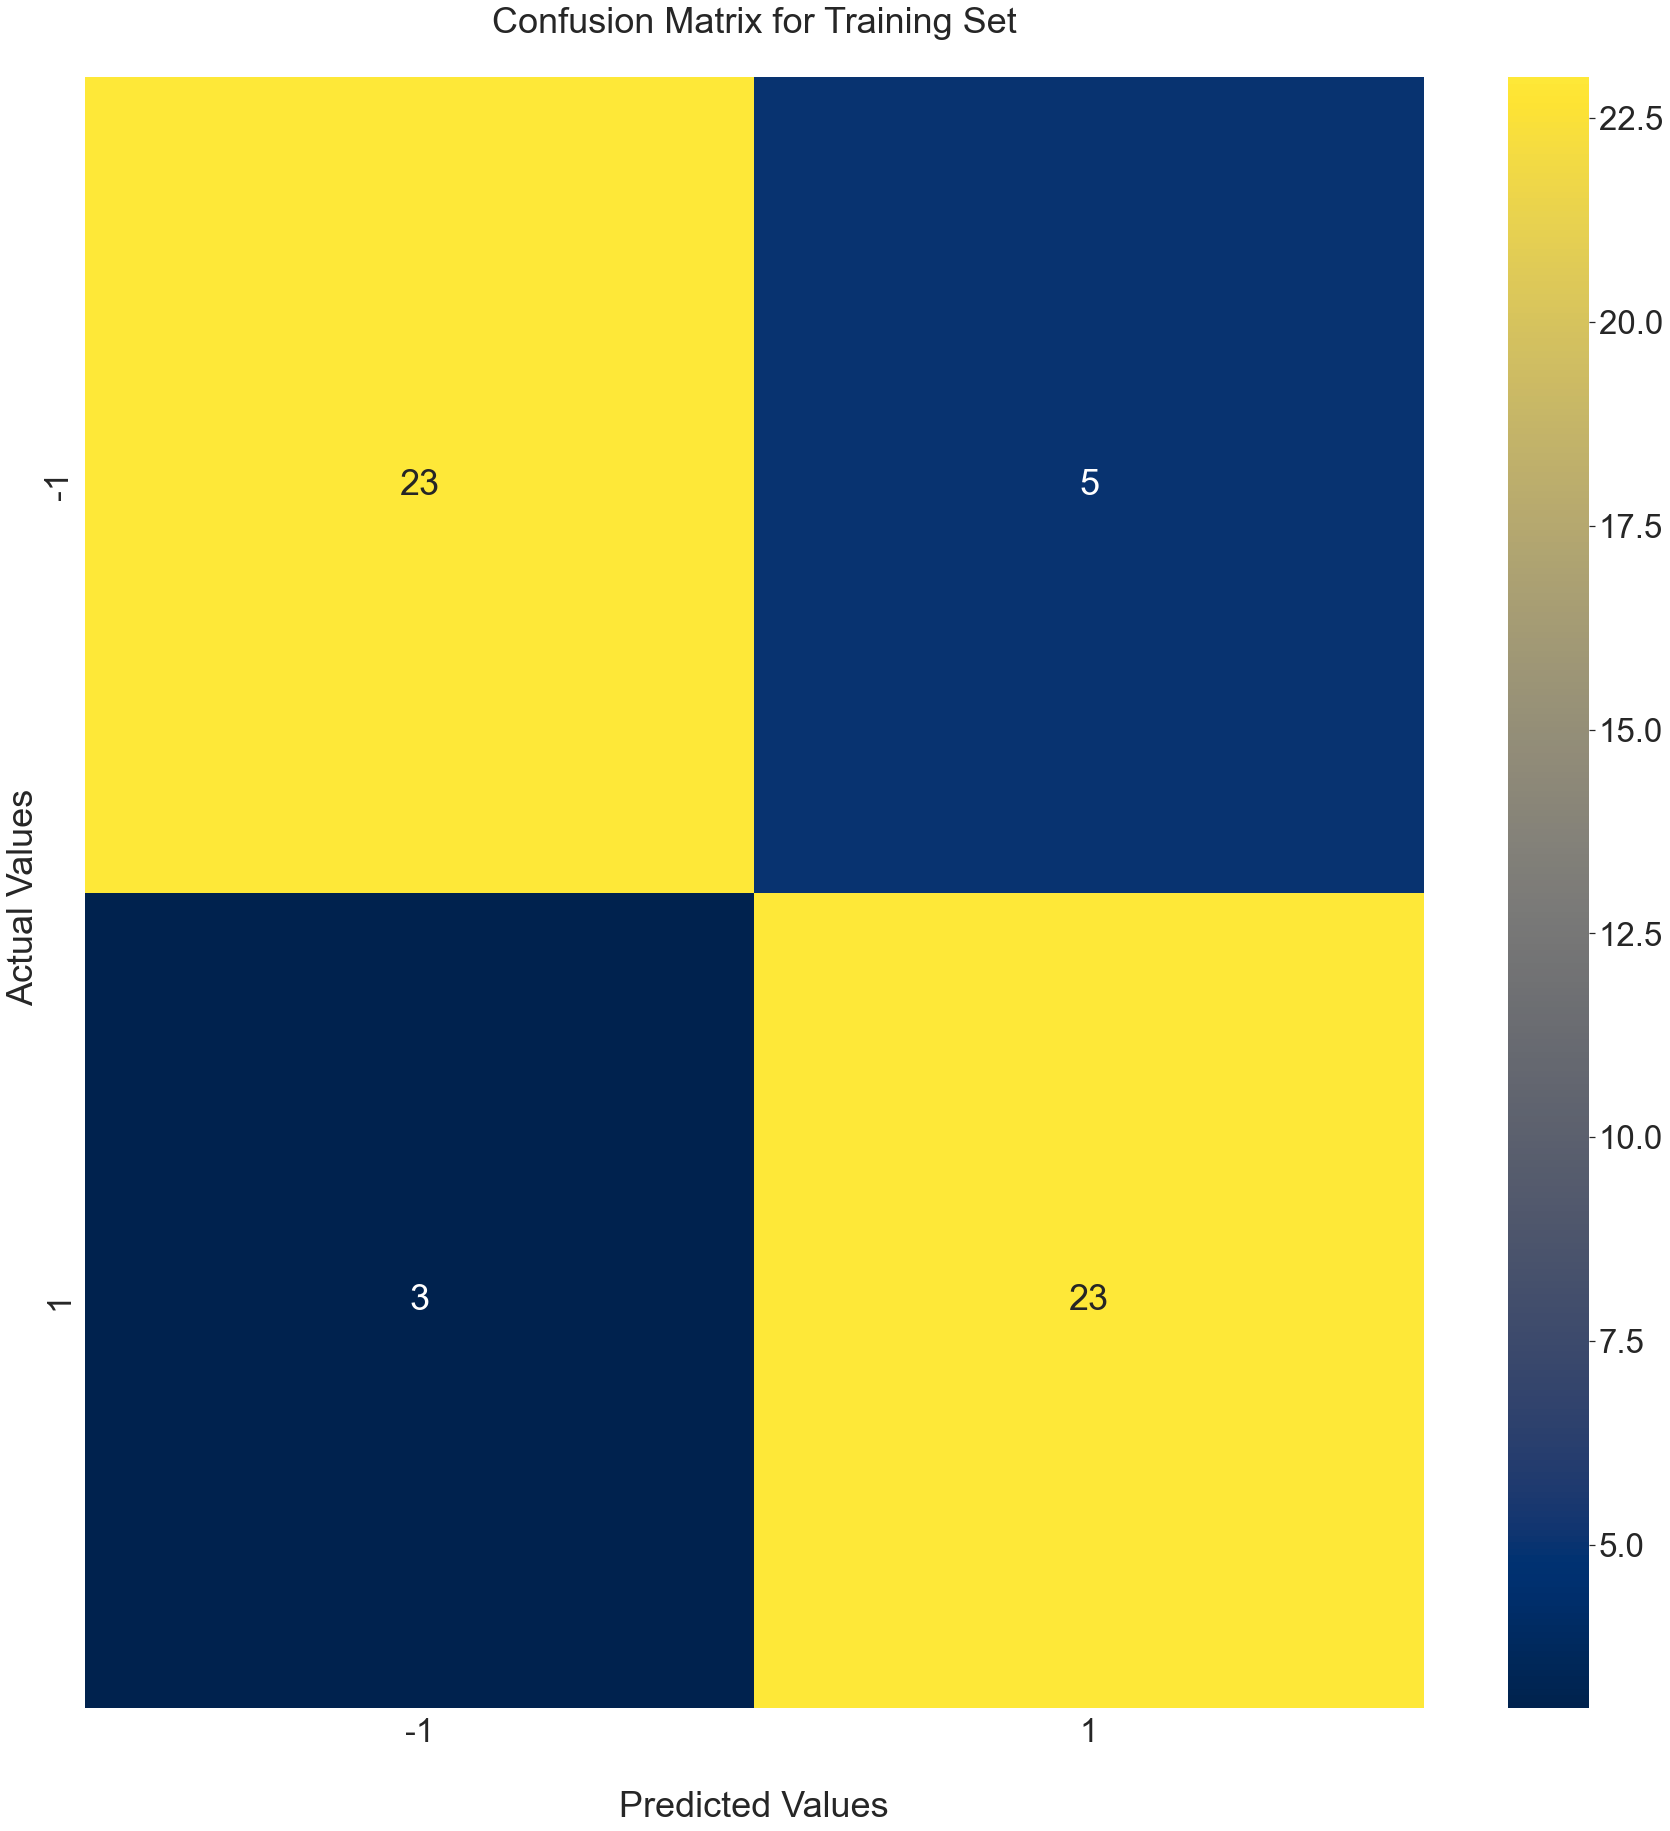

In [168]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0]
cf_matrix = confusion_matrix(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], np.select([pred<=0, pred>0], [-1, 1], 0))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Training Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1', '1'])
ax.yaxis.set_ticklabels(['-1', '1'])
ax

In [169]:
# Root mean squared error for the test set
rmse_test = np.sqrt(mean_squared_error(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_test

1.1226031281920403

<AxesSubplot:title={'center':'Confusion Matrix for Test Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

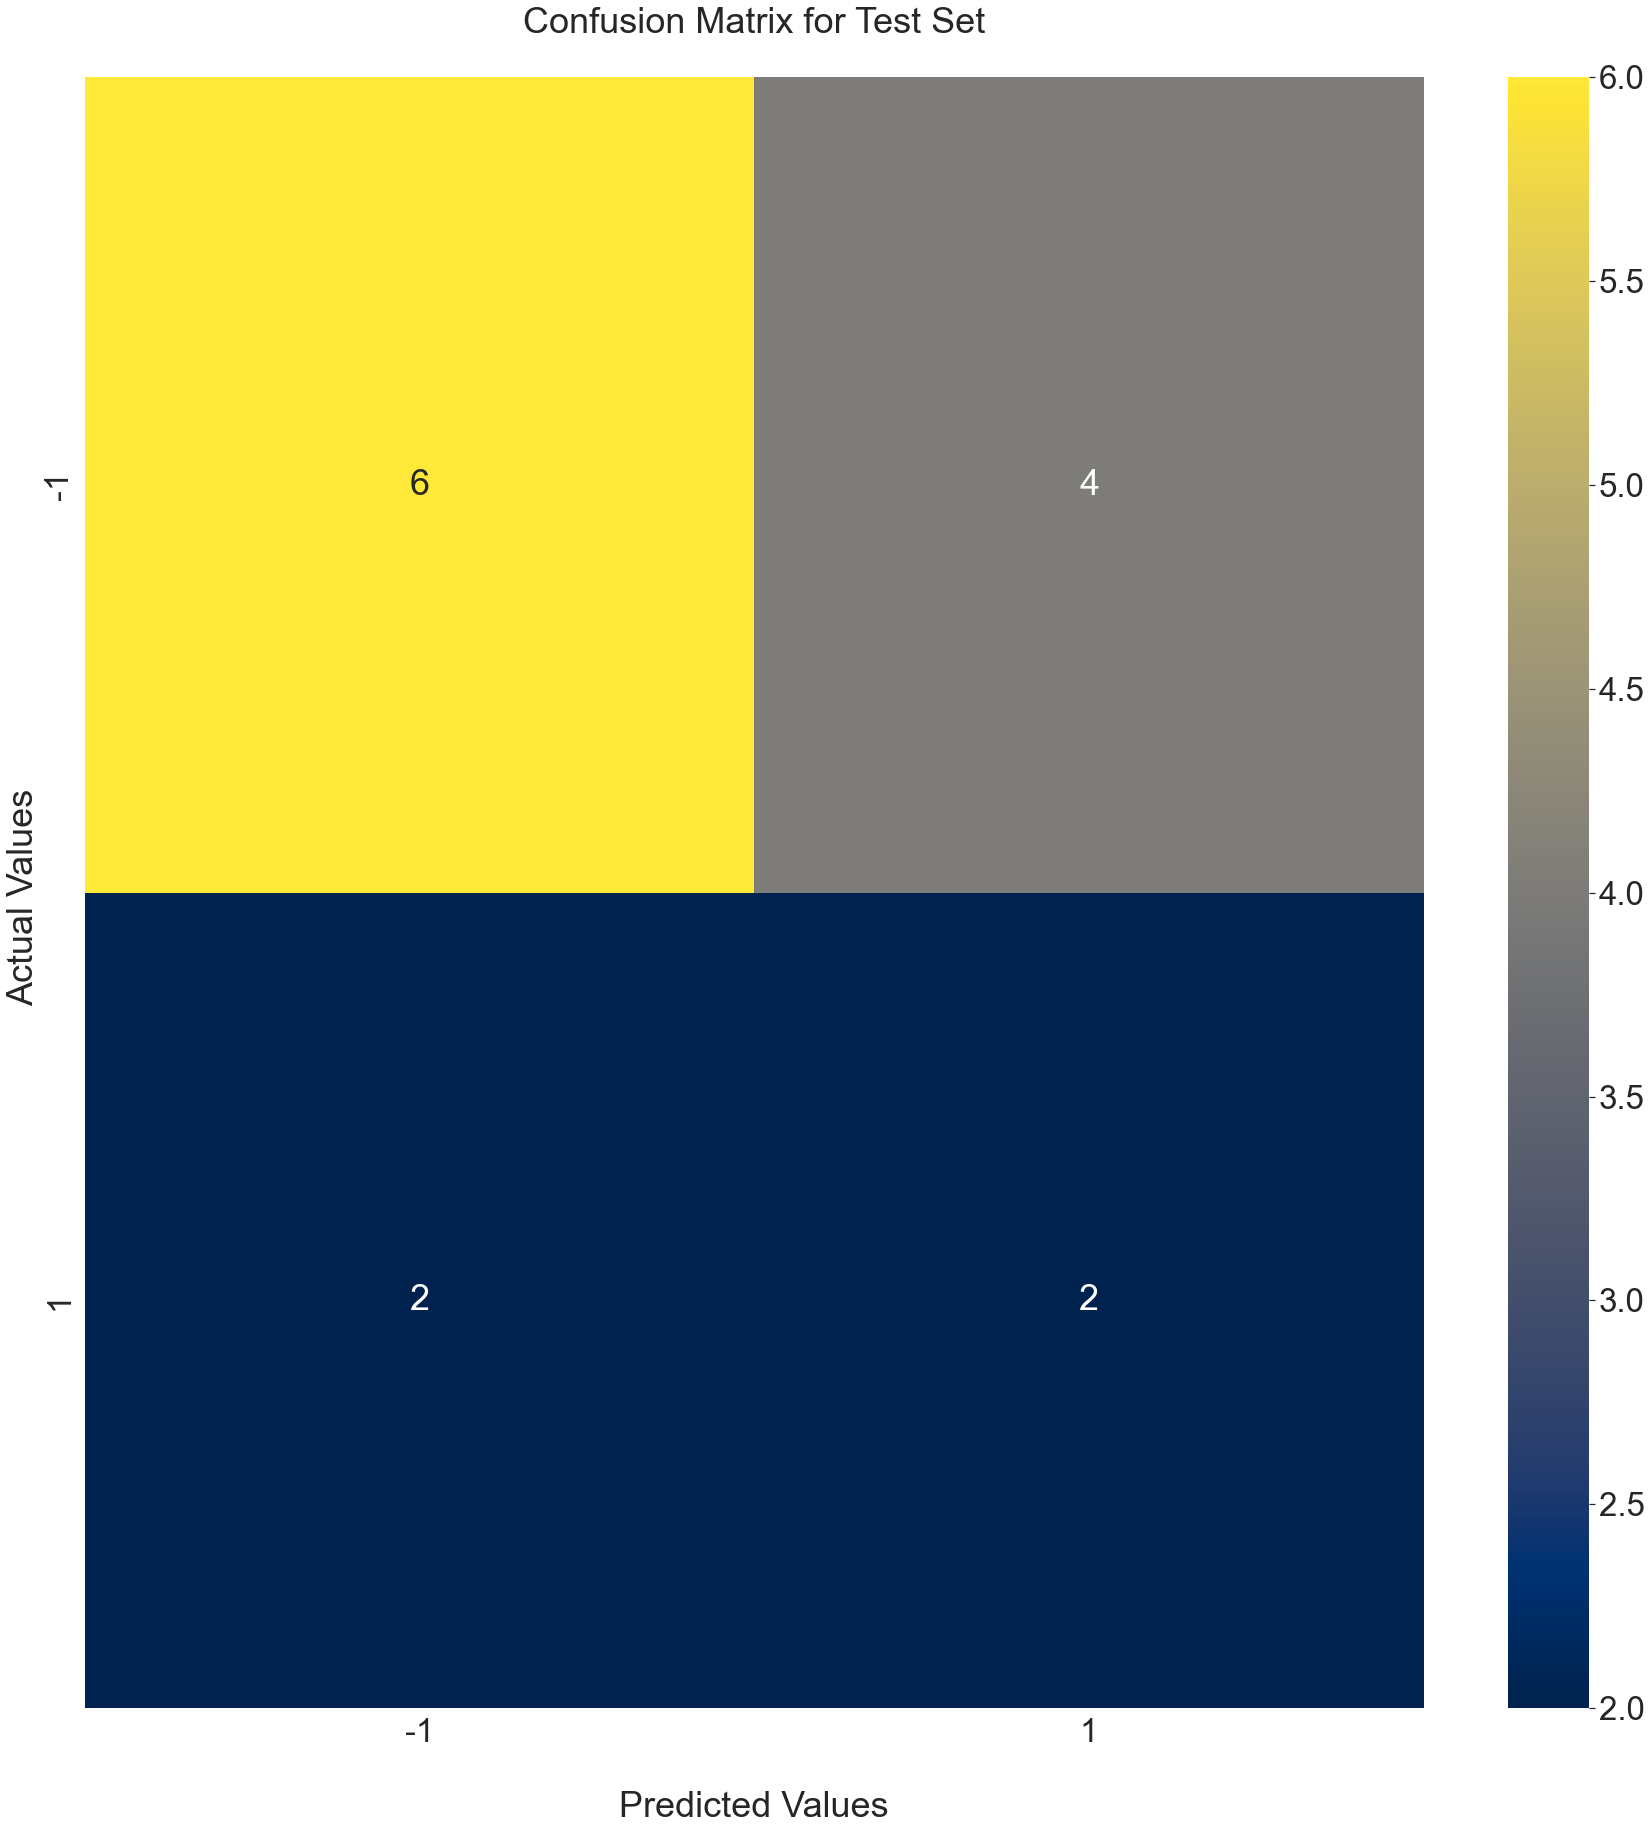

In [170]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0]
cf_matrix = confusion_matrix(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], np.select([pred<=0, pred>0], [-1, 1], 0))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Test Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1', '1'])
ax.yaxis.set_ticklabels(['-1', '1'])
ax

In [171]:
# Recommender system for a user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_user_based_CF(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Tom:


In [172]:
# Prepare data for Jaccard Similarity

In [173]:
# Keep the ratings in binary values only
user_ratings_df = user_ratings_df.replace(-1, 0)
train_user_ratings_df = train_user_ratings_df.replace(-1, 0)
train_user_ratings = train_user_ratings.replace(-1, 0)
test_user_ratings = test_user_ratings.replace(-1, 0)

In [174]:
train_user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [175]:
test_user_ratings

,UserID,ProfileID,Rating
51,8,10,0
62,10,7,1
2,1,4,1
59,10,2,0
66,11,9,1
6,2,3,0
67,11,10,0
29,5,7,1
49,8,7,0
56,9,6,0


In [176]:
# Item-based Collaborative Filtering with Jaccard Similarity

In [177]:
import scipy.spatial

jaccard = scipy.spatial.distance.cdist(train_user_ratings_df.T, train_user_ratings_df.T, metric="jaccard")
sim_profiles_distance_df = pd.DataFrame(jaccard, index=train_user_ratings_df.T.index.values, columns=train_user_ratings_df.T.index.values)

In [178]:
# Find nearest profiles with Jaccard distance
import math

def findNearestProfilesWithJaccard(profile_id):
    k = math.isqrt(len(train_user_ratings_df.T.index))

    # Extract the sorted distance of its neighbours for a profile
    sim_profiles_distances_series = sim_profiles_distance_df[profile_id].nsmallest(k)
    sim_profiles = [i for i in sim_profiles_distances_series.index]
    sim_profiles_distances = sim_profiles_distances_series.values.tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if profile_id in sim_profiles:
        # The index of the profile in the list of similar users
        index_of_profile_in_sim = sim_profiles.index(profile_id)

        # Remove the profile from the list of similar profiles
        sim_profiles.pop(index_of_profile_in_sim)

        # Remove the profile from the list of similar profiles distances
        sim_profiles_distances.pop(index_of_profile_in_sim)

    # print("The nearest users to User {} are:".format(user_id), ["User {}".format(i) for i in sim_users])
    # print("The distance from User {}:".format(user_id), sim_users_distances)
    return sim_profiles, sim_profiles_distances

# findNearestProfilesWithJaccard(6)

In [179]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the user
    profile_ratings = train_user_ratings_df.T.iloc[index_of_profile].values.tolist()

    # Find the nearest neighbors of the profile
    sim_profiles, sim_profiles_distances = findNearestProfilesWithJaccard(profile_id)

    # Get the ratings for the similar profiles
    sim_profiles_ratings = [train_user_ratings_df.T.loc[i].values.tolist() for i in sim_profiles]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([(1 - sim_profiles_distances[i]) * (sim_profiles_ratings[i][index_of_user] - average(train_user_ratings_df.T.loc[sim_profiles[i]].values.tolist())) for i in range(len(sim_profiles))])
    denominator = sum(1 - sim_profiles_distances[i] for i in range(len(sim_profiles)))

    if denominator > 0:
        predicted_rating = average(profile_ratings) + numerator / denominator 
    else:
        predicted_rating = average(profile_ratings)
    
    # print("Returned", sim_users, sim_users_distances)
    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

predict_rating_with_neighbor_correlations(3, 2)

0.7272727272727273

In [180]:
def recommender_system_item_based_CF_Jaccard(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [181]:
# Generating the entire item-based jaccard prediction matrix
predicted_ratings = train_user_ratings_df.T.copy()

for user_id in train_user_ratings_df.index:
    print(user_id)
    recommender_system_item_based_CF_Jaccard(user_id)
pd.DataFrame(predicted_ratings)

1
2
3
4
5
6
7
8
9
10
11


UserID,1,2,3,4,5,6,7,8,9,10,11
ProfileID,,,,,,,,,,,
1,0.051948,0.051948,0.480519,0.480519,0.051948,0.623377,1.051948,0.051948,0.051948,0.051948,0.051948
2,0.127273,0.127273,0.727273,0.127273,0.127273,1.127273,0.527273,0.127273,0.727273,0.127273,0.127273
3,0.090909,1.090909,0.090909,0.090909,1.090909,0.090909,0.090909,1.090909,0.090909,0.090909,0.090909
4,0.254545,0.854545,0.054545,0.054545,0.854545,0.054545,0.054545,0.254545,0.054545,0.254545,0.254545
5,-0.040404,-0.040404,0.404040,0.515152,-0.040404,0.959596,0.959596,-0.040404,0.404040,-0.040404,-0.040404
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,-0.045455,-0.045455,0.704545,-0.045455,-0.045455,0.954545,0.954545,-0.045455,0.704545,-0.045455,-0.045455
9,-0.090909,0.909091,-0.090909,-0.090909,0.909091,-0.090909,-0.090909,0.909091,-0.090909,-0.090909,-0.090909


In [182]:
# Turn pivot like table to original dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings.to_records())
predicted_ratings_df = predicted_ratings_df.melt(id_vars=["ProfileID"], var_name="UserID", value_name="Rating")
predicted_ratings_df = predicted_ratings_df.astype({"UserID": int, "ProfileID": int, "Rating": float})
predicted_ratings_df = predicted_ratings_df[["UserID", "ProfileID", "Rating"]]
predicted_ratings_df

,UserID,ProfileID,Rating
0,1,1,0.051948
1,1,2,0.127273
2,1,3,0.090909
3,1,4,0.254545
4,1,5,-0.040404
...,...,...,...
116,11,7,0.000000
117,11,8,-0.045455
118,11,9,-0.090909
119,11,10,-0.129870


In [183]:
train_user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [184]:
test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index()

Rating
UserID ProfileID        
1      4               1
       8               0
2      3               0
4      2               0
5      7               1
8      7               0
       9               0
       10              0
9      6               0
10     2               0
       7               1
11     8               0
       9               1
       10              0

In [185]:
# Get only ratings that UserID and ProfileID exist in train_user_ratings
predicted_ratings_for_train = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(train_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      2          0.127273
       3          0.090909
       6          0.000000
       7          0.000000
2      4          0.854545

In [186]:
# Get only ratings that UserID and ProfileID exist in test_user_ratings
predicted_ratings_for_test = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(test_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      4          0.254545
       8         -0.045455
2      3          1.090909
4      2          0.127273
5      7          0.000000

In [187]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

# Root mean squared error for the training set
rmse_train = np.sqrt(mean_squared_error(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_train

0.36583147414491773

<AxesSubplot:title={'center':'Confusion Matrix for Training Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

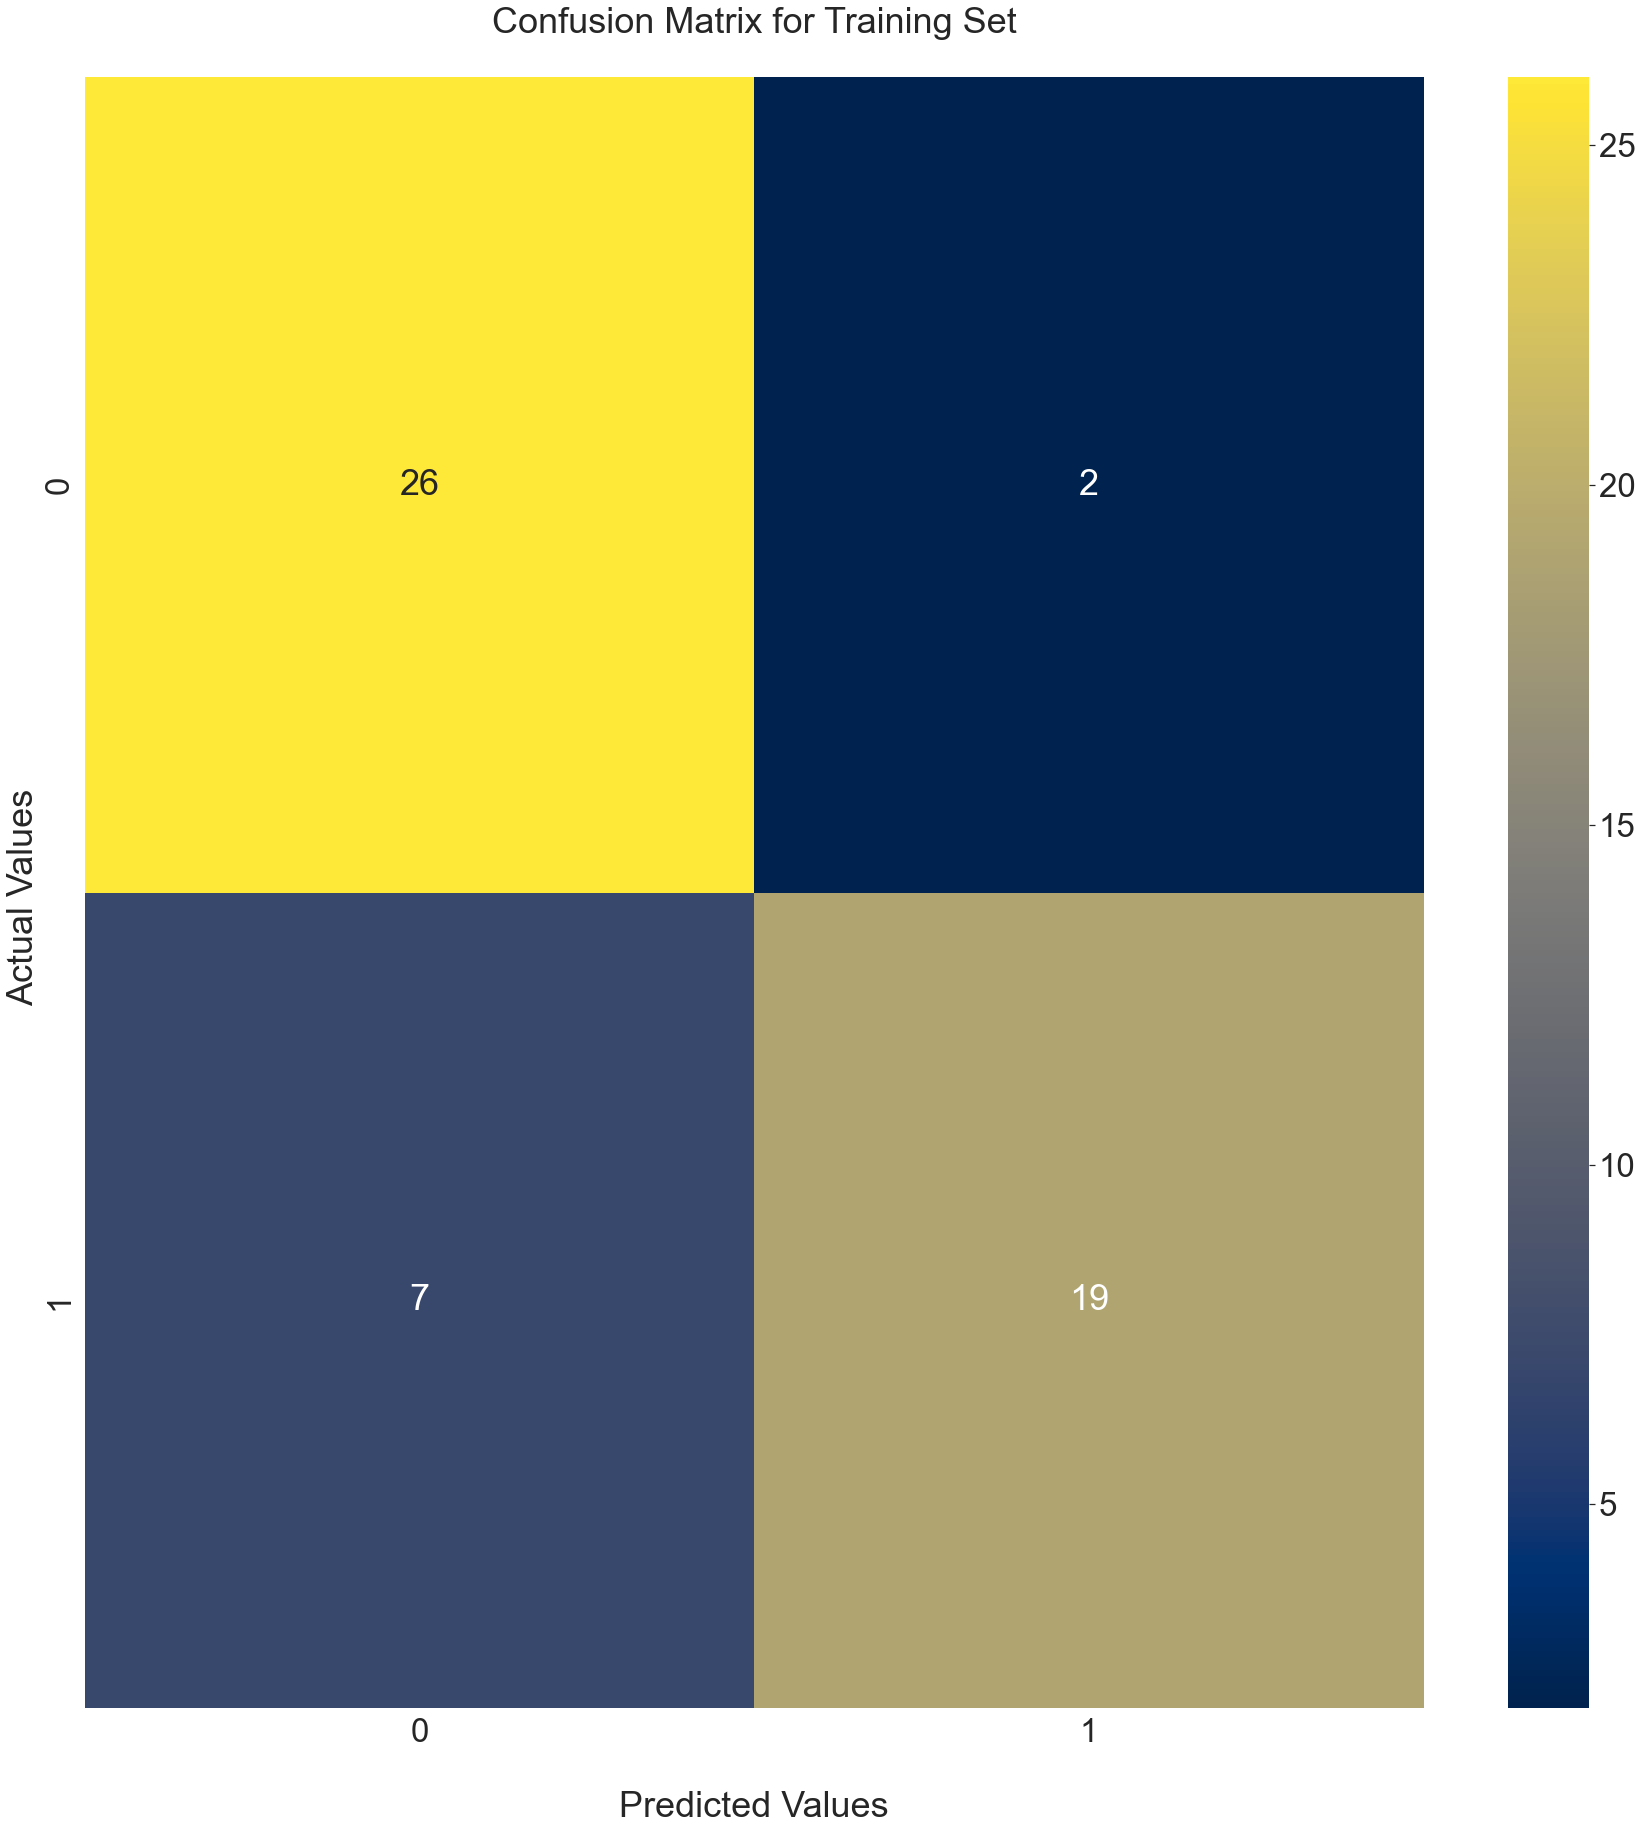

In [188]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], predicted_ratings_for_train.round(decimals = 0).set_index(["UserID", "ProfileID"]).sort_index().values[:, 0].astype(int))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Training Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax

In [189]:
# Root mean squared error for the test set
rmse_test = np.sqrt(mean_squared_error(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_test

0.6454552920487091

<AxesSubplot:title={'center':'Confusion Matrix for Test Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

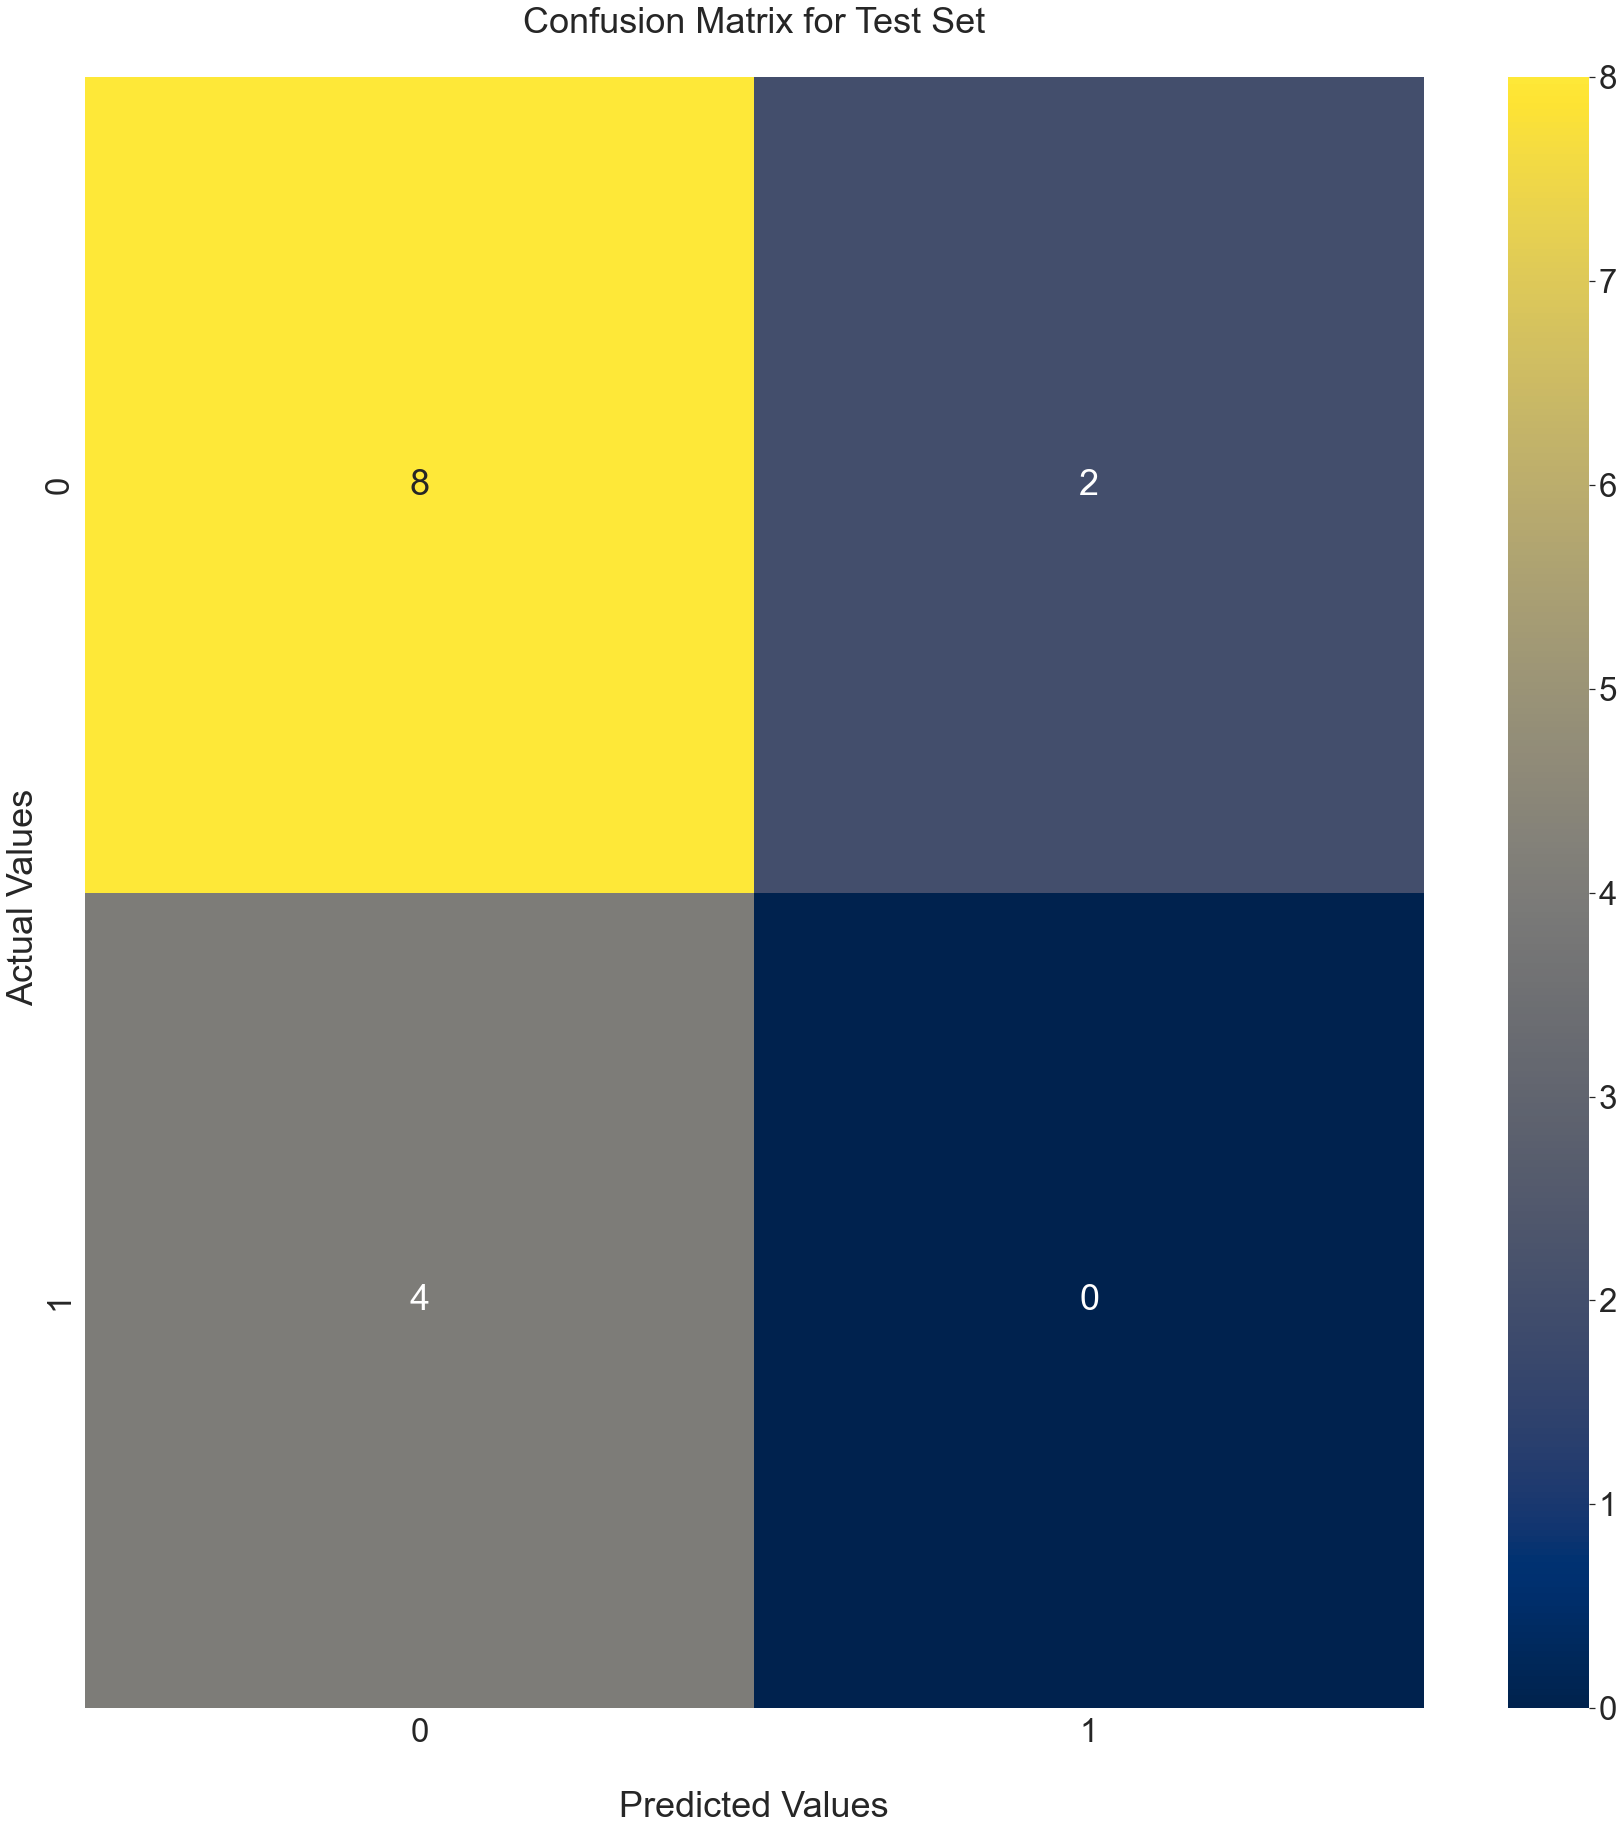

In [190]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], predicted_ratings_for_test.round(decimals = 0).set_index(["UserID", "ProfileID"]).sort_index().values[:, 0].astype(int))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Test Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax

In [191]:
# Recommender system for a user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_item_based_CF_Jaccard(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Amy:
('John', 0.9090909090909092)


# User-based Collaborative Filtering with Jaccard Similarity

In [192]:
import scipy.spatial

jaccard = scipy.spatial.distance.cdist(train_user_ratings_df, train_user_ratings_df, metric="jaccard")
sim_users_distance_df = pd.DataFrame(jaccard, index=train_user_ratings_df.index.values, columns=train_user_ratings_df.index.values)

In [193]:
# Find nearest users with Jaccard distance
import math

def findNearestUsersWithJaccard(user_id):
    k = math.isqrt(len(train_user_ratings_df.index))

    # Extract the sorted distance of its neighbours for a user
    sim_users_distances_series = sim_users_distance_df[user_id].nsmallest(k)
    sim_users = [i for i in sim_users_distances_series.index]
    sim_users_distances = sim_users_distances_series.values.tolist()

    # Case when the target user is not in the list, multiple values are the same
    if user_id in sim_users:
        # The index of the user in the list of similar users
        index_of_user_in_sim = sim_users.index(user_id)

        # Remove the user from the list of similar users
        sim_users.pop(index_of_user_in_sim)

        # Remove the user from the list of similar users distances
        sim_users_distances.pop(index_of_user_in_sim)

    # print("The nearest users to User {} are:".format(user_id), ["User {}".format(i) for i in sim_users])
    # print("The distance from User {}:".format(user_id), sim_users_distances)
    return sim_users, sim_users_distances

# findNearestUsersWithJaccard(6)

In [194]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the user
    user_ratings = train_user_ratings_df.iloc[index_of_user].values.tolist()

    # Find the nearest neighbors of the user
    sim_users, sim_users_distances = findNearestUsersWithJaccard(user_id)

    # Get the ratings for the similar users
    sim_users_ratings = [train_user_ratings_df.loc[i].values.tolist() for i in sim_users]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([(1 - sim_users_distances[i]) * (sim_users_ratings[i][index_of_profile] - average(train_user_ratings_df.loc[sim_users[i]].values.tolist())) for i in range(len(sim_users))])
    denominator = sum(1 - sim_users_distances[i] for i in range(len(sim_users)))

    if denominator > 0:
        predicted_rating = average(user_ratings) + numerator / denominator 
    else:
        predicted_rating = average(user_ratings)
    
    # print("Returned", sim_users, sim_users_distances)
    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(9, 55)

In [195]:
def recommender_system_user_based_CF_Jaccard(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [196]:
# Generating the entire user-based jaccard prediction matrix
predicted_ratings = train_user_ratings_df.T.copy()

for user_id in train_user_ratings_df.index:
    print(user_id)
    recommender_system_user_based_CF_Jaccard(user_id)
pd.DataFrame(predicted_ratings)

1
2
3
4
5
6
7
8
9
10
11


UserID,1,2,3,4,5,6,7,8,9,10,11
ProfileID,,,,,,,,,,,
1,0.0,2.775558e-17,0.404040,0.412587,2.775558e-17,0.545455,1.171717,0.090909,0.404040,0.0,0.0
2,0.0,2.775558e-17,0.959596,0.797203,2.775558e-17,0.989899,0.727273,0.090909,0.959596,0.0,0.0
3,1.0,2.500000e-01,-0.040404,-0.202797,2.500000e-01,-0.010101,0.171717,1.090909,-0.040404,1.0,1.0
4,0.0,1.000000e+00,-0.040404,-0.202797,1.000000e+00,-0.010101,0.171717,0.090909,-0.040404,0.0,0.0
5,0.0,2.775558e-17,-0.040404,0.797203,2.775558e-17,0.989899,0.616162,0.090909,0.515152,0.0,0.0
6,0.0,2.775558e-17,-0.040404,-0.202797,2.775558e-17,-0.010101,0.171717,0.090909,-0.040404,0.0,0.0
7,0.0,2.775558e-17,-0.040404,-0.202797,2.775558e-17,-0.010101,0.171717,0.090909,-0.040404,0.0,0.0
8,0.0,2.775558e-17,0.959596,0.181818,2.775558e-17,0.434343,0.727273,0.090909,0.959596,0.0,0.0
9,0.0,7.500000e-01,-0.040404,-0.202797,7.500000e-01,-0.010101,0.171717,0.090909,-0.040404,0.0,0.0


In [197]:
# Turn pivot like table to original dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings.to_records())
predicted_ratings_df = predicted_ratings_df.melt(id_vars=["ProfileID"], var_name="UserID", value_name="Rating")
predicted_ratings_df = predicted_ratings_df.astype({"UserID": int, "ProfileID": int, "Rating": float})
predicted_ratings_df = predicted_ratings_df[["UserID", "ProfileID", "Rating"]]
predicted_ratings_df

,UserID,ProfileID,Rating
0,1,1,0.0
1,1,2,0.0
2,1,3,1.0
3,1,4,0.0
4,1,5,0.0
...,...,...,...
116,11,7,0.0
117,11,8,0.0
118,11,9,0.0
119,11,10,0.0


In [198]:
train_user_ratings_df

ProfileID,1,2,3,4,5,6,7,8,9,10,11
UserID,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [199]:
test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index()

Rating
UserID ProfileID        
1      4               1
       8               0
2      3               0
4      2               0
5      7               1
8      7               0
       9               0
       10              0
9      6               0
10     2               0
       7               1
11     8               0
       9               1
       10              0

In [200]:
# Get only ratings that UserID and ProfileID exist in train_user_ratings
predicted_ratings_for_train = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(train_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID        
1      2             0.0
       3             1.0
       6             0.0
       7             0.0
2      4             1.0

In [201]:
# Get only ratings that UserID and ProfileID exist in test_user_ratings
predicted_ratings_for_test = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(test_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID              
1      4          0.000000e+00
       8          0.000000e+00
2      3          2.500000e-01
4      2          7.972028e-01
5      7          2.775558e-17

In [202]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

# Root mean squared error for the training set
rmse_train = np.sqrt(mean_squared_error(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_train

0.3655103035181788

<AxesSubplot:title={'center':'Confusion Matrix for Training Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

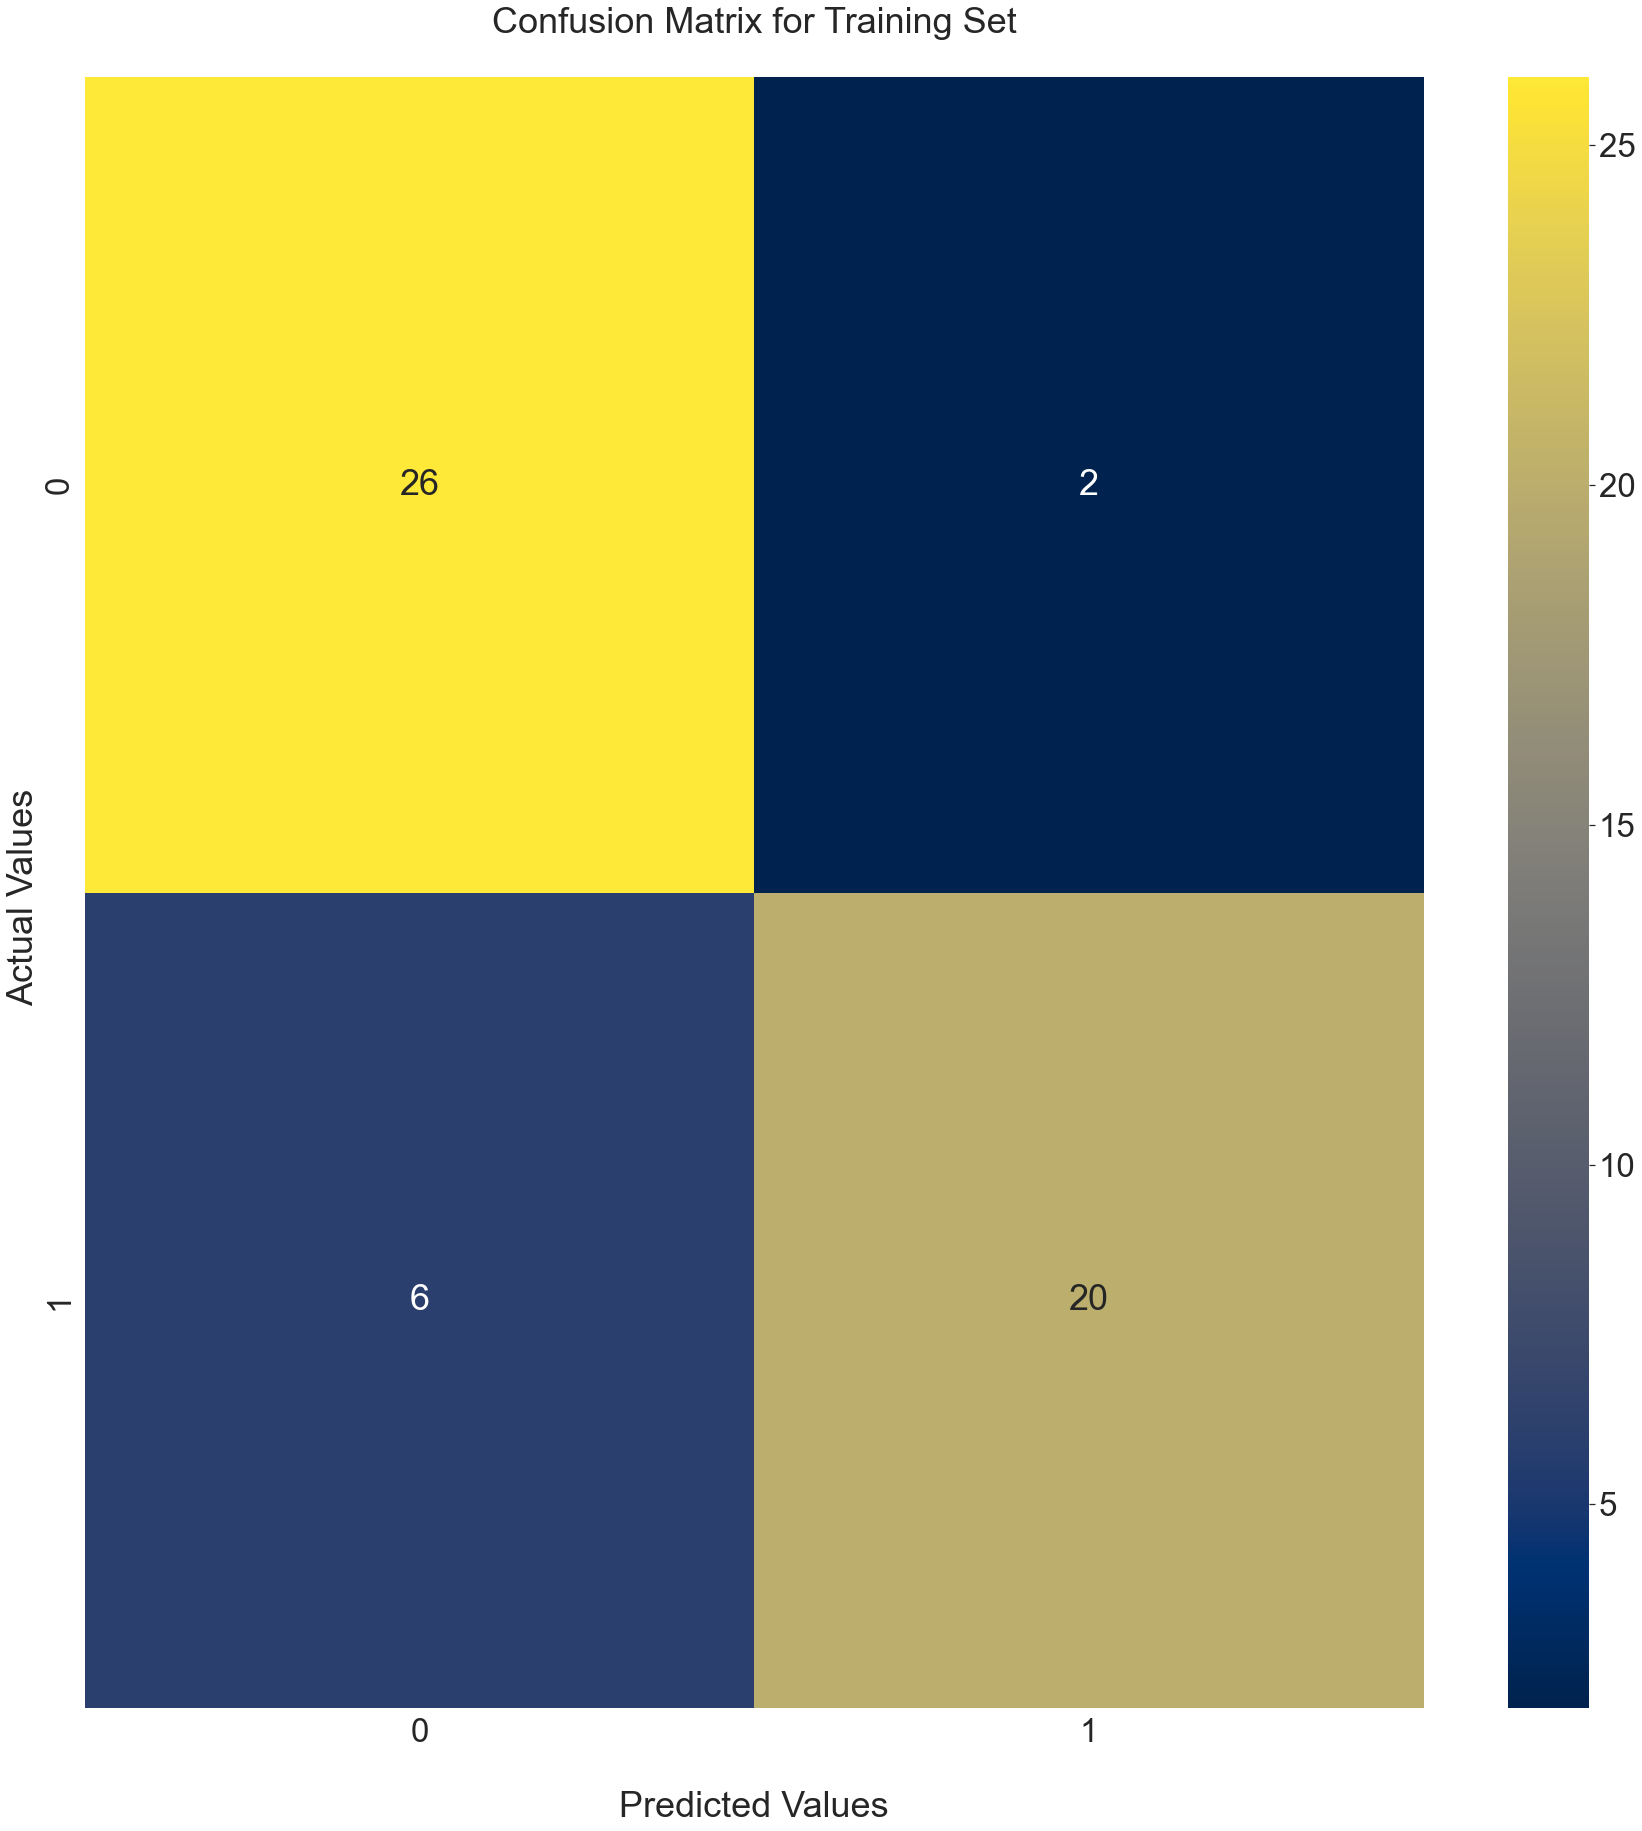

In [203]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], predicted_ratings_for_train.round(decimals = 0).set_index(["UserID", "ProfileID"]).sort_index().values[:, 0].astype(int))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Training Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax

In [204]:
# Root mean squared error for the test set
rmse_test = np.sqrt(mean_squared_error(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_test

0.5809141917688685

<AxesSubplot:title={'center':'Confusion Matrix for Test Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

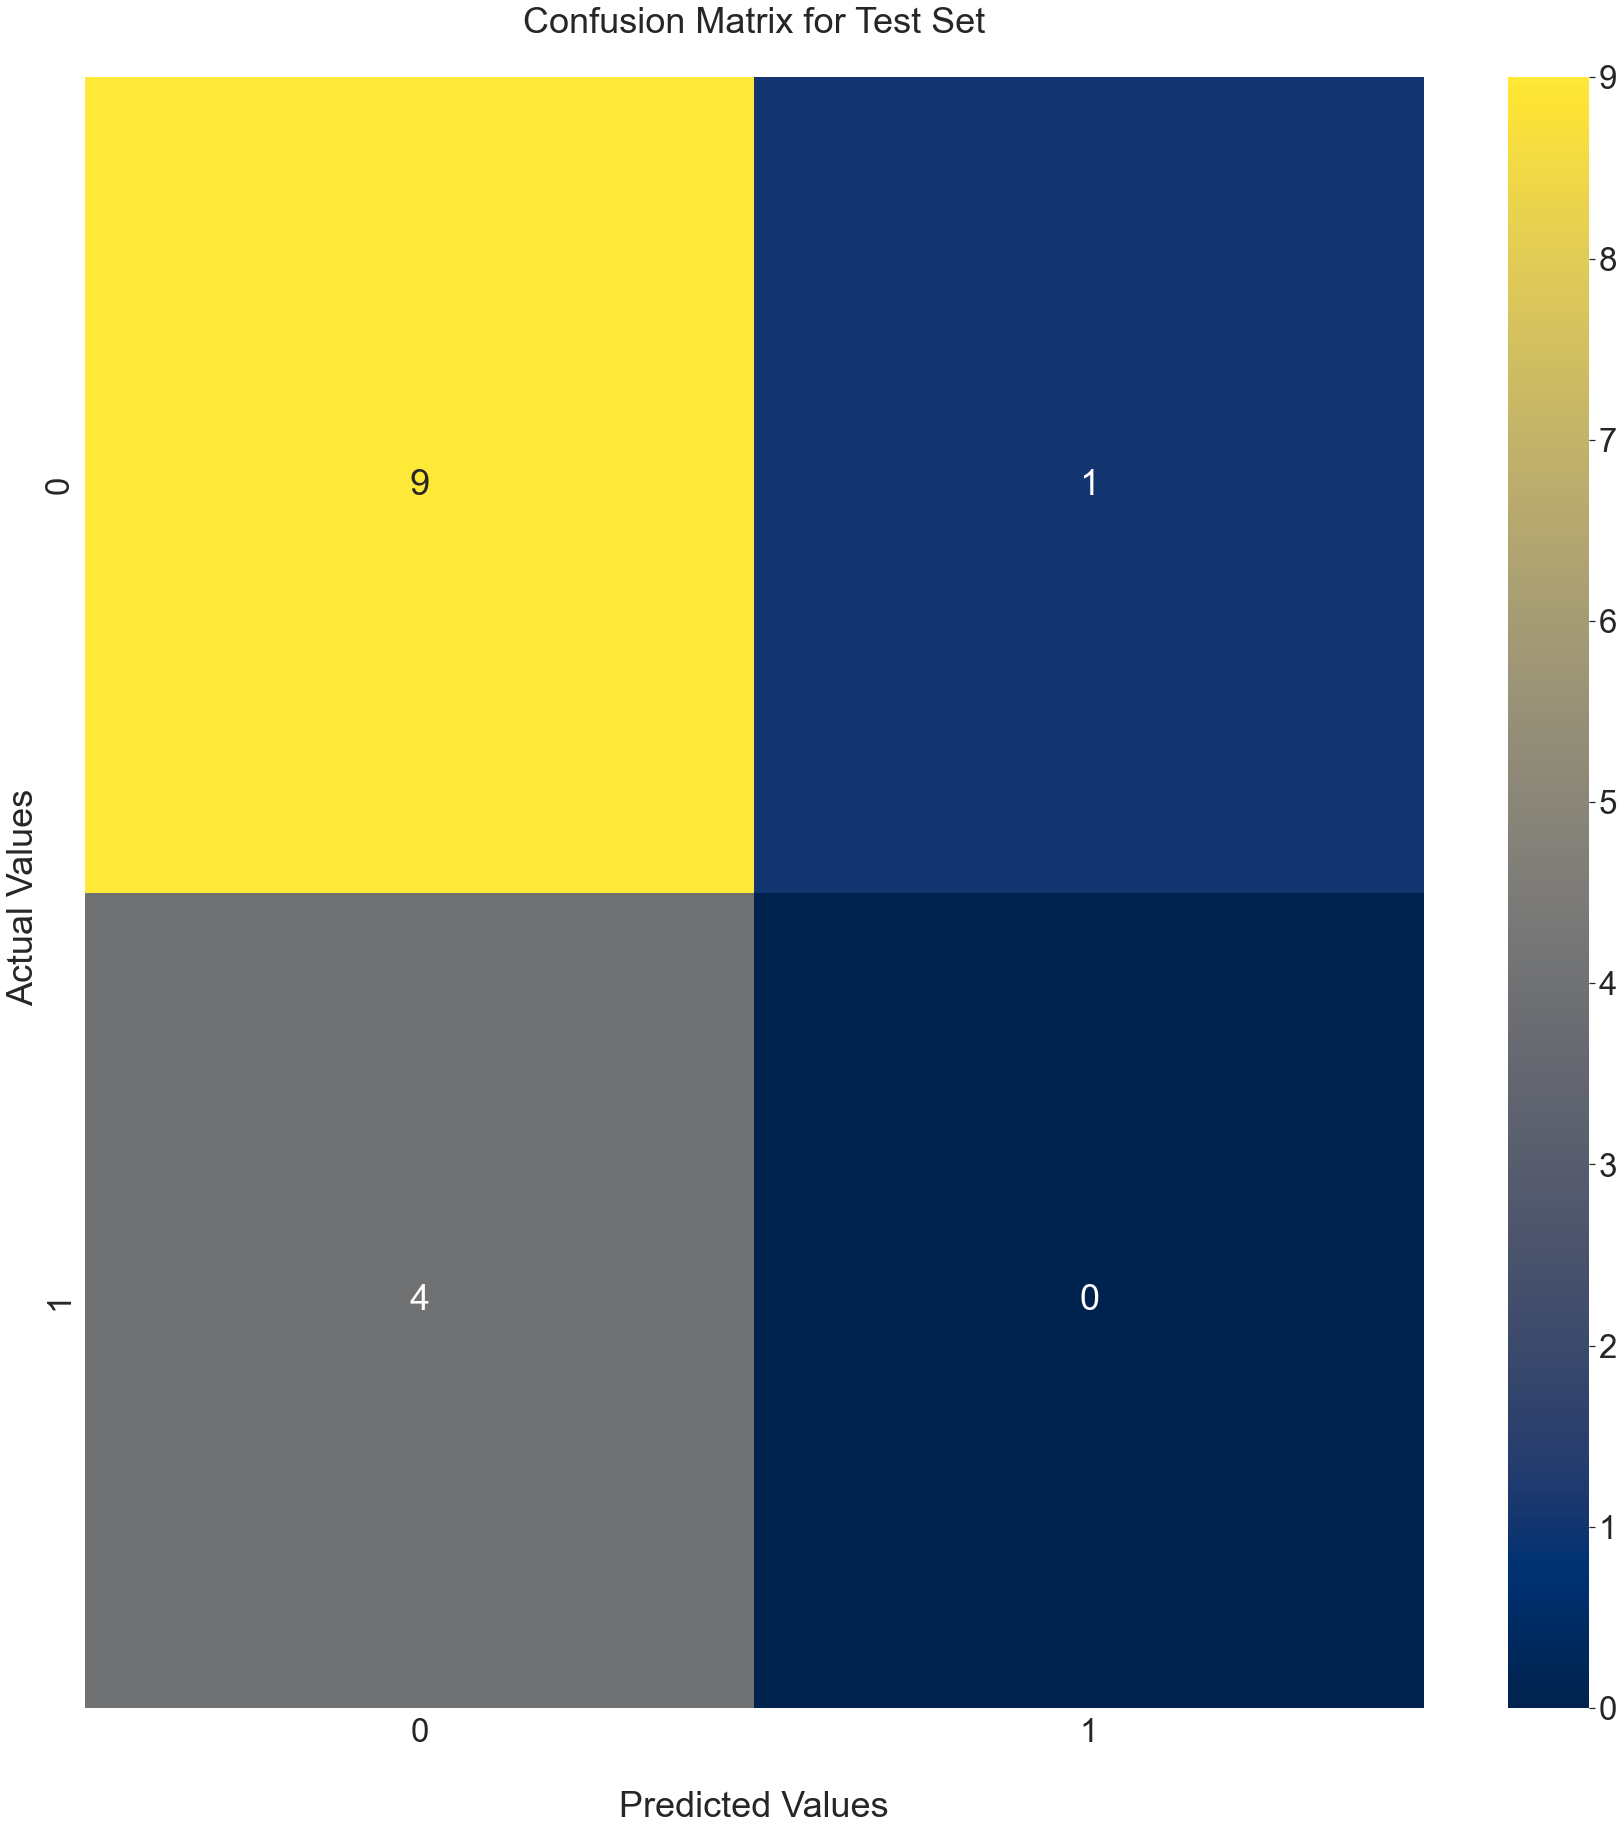

In [205]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], predicted_ratings_for_test.round(decimals = 0).set_index(["UserID", "ProfileID"]).sort_index().values[:, 0].astype(int))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Test Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax

In [206]:
# Recommender system for a user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_user_based_CF_Jaccard(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User Amy:


# Visualize the network graph

Using the non pivot version (ratings) to visualize.

In [486]:
# Keep only "like" edges
ratings = ratings[ratings["Rating"] == 1]

## For small dataset visualization

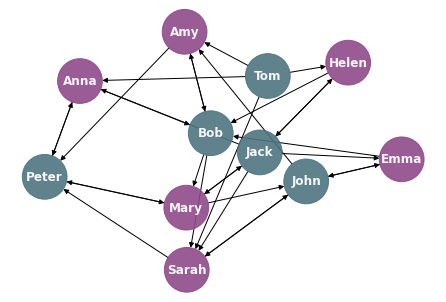

In [492]:
# Remarks: This won't plot node without positive rating associated with it.
# As negative rating has been remove before

import matplotlib.pyplot as plt
import networkx as nx

gr = nx.from_pandas_edgelist(ratings, "UserID", "ProfileID", "Rating", create_using=nx.DiGraph())

mapping = dict(info[["UserID", "Name"]].values.tolist())
color_map = []
for node in gr.nodes():
    if info.loc[info["UserID"] == node, "Gender"].values[0] == "M":
        color_map.append([0.3, 0.46, 0.5, 0.9])
    else:
        color_map.append([0.56, 0.29, 0.54, 0.9])

gr = nx.relabel_nodes(gr, mapping)
pos = nx.fruchterman_reingold_layout(gr)
nx.draw(gr, pos, with_labels=True, node_size=2000, node_color=color_map, font_color="whitesmoke", font_weight="semibold")
plt.show()

## For large dataset visualization

In [99]:
# Only execute this with large dataset

import graph_tool.all as gt 
import random
from IPython.display import Image

network_graph_file = "network-graph-" + str(random.randint(0, 2e9)) + ".png"

g = gt.Graph(directed=True)
vmap = g.add_edge_list(ratings[["UserID", "ProfileID"]].to_numpy(), hashed=True)
pos = gt.fruchterman_reingold_layout(g, n_iter=10)

v_size = g.new_vertex_property("double")
g.vertex_properties["v_size"] = v_size

v_font_size = g.new_vertex_property("double")
g.vertex_properties["v_font_size"] = v_font_size

v_pen_width = g.new_vertex_property("double")
g.vertex_properties["v_pen_width"] = v_pen_width
 
for v in g.vertices():
    v_size[v] = (1 + v.in_degree() * 4) * (1000 / g.num_vertices())
    v_font_size[v] = (1 + v.in_degree()) * (400 / g.num_vertices())
    v_pen_width[v] = (1 + v.in_degree()) * (100 / g.num_vertices())

gt.graph_draw(g, vertex_text=vmap, pos=pos, vertex_size=v_size, vertex_font_size=v_font_size, vertex_fill_color=[0.2, 0.4, 0.53, 0.9], vertex_pen_width=v_pen_width, vertex_font_family="roboto", output_size=(2048, 2048), bg_color=[1, 1, 1, 1], output=network_graph_file)

Image(url=network_graph_file)

# Below are the cells that I haven't finished yet.

In [ ]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
# def standardize(row):
#     new_row = (row - row.mean()) / (row.max() - row.min())
#     return new_row

# user_ratings_std = user_ratings.apply(standardize)
# user_ratings_std

In [32]:
# Profile-Profile Similarity with Cosine similarity

def calculate_similarity(data):
    similarity = cosine_similarity(data)
    return similarity

profile_similarity = calculate_similarity(user_ratings.T)
profile_similarity_df = pd.DataFrame(profile_similarity, index=user_ratings_df.columns.values, columns=user_ratings_df.columns.values)
profile_similarity_df

,1,2,5
1,1.000000,0.000000,0.707107
2,0.000000,1.000000,0.707107
5,0.707107,0.707107,1.000000


In [34]:
# Making recommendations

def get_similar_profile(profile_id, user_rating):
    similar_score = profile_similarity_df[profile_id] * user_rating
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

result = get_similar_profile(1, 1)
result


1    1.000000
5    0.707107
2    0.000000
Name: 1, dtype: float64